In [ ]:
#k-means
from mpl_toolkits.mplot3d import axes3d
from scipy.spatial import ConvexHull
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_blobs
from collections import Counter
import math
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.decomposition import PCA
from gap_statistic import OptimalK
from numpy import linalg as LA
from numpy.linalg import multi_dot
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics

rand_iter = 10
Npts=1000
rand_initializations=3
maxk = 10
#https://stackoverflow.com/questions/61859098/maximum-volume-inscribed-ellipsoid-in-a-polytope-set-of-points?fbclid=IwAR2DcaQSvqd368lstBayY-atAbQxCVa_EecgS7HE-mrpK6EanO9qbsX2Drg
#From: https://stackoverflow.com/a/61786434/752843

def random_point_ellipse(W,d):
  # random angle
  alpha = 2 * np.pi * np.random.random()
  # vector on that angle
  pt = np.array([np.cos(alpha),np.sin(alpha)])
  # Ellipsoidize it
  return W@pt+d

def GetRandom(dims, Nptss):
  if dims==2:
    W = sklearn.datasets.make_spd_matrix(2)
    d = np.array([2,3])
    #form clusters 2d 
    centers = [[0, 1], [1.5, 1.5], [1,1],[1,2],[2,2],[2.5,2.5],[0,2.5],[1,2.5]]
    stds=[0.8, 0.8,0.8,0.8,0.8,0.8,0.8,0.8]
    points, labels_true = make_blobs(n_samples=Npts, centers=centers, cluster_std=stds, random_state=0)
  else:
    raise Exception("dims must be 2 or 3!")
  return points

def GetHull(points):
  dim  = points.shape[1]
  hull = ConvexHull(points)
  A    = hull.equations[:,0:dim]
  b    = hull.equations[:,dim]
  return A, -b, hull #Negative moves b to the RHS of the inequality

def FindMaximumVolumeInscribedEllipsoid(points,rand_iter):
  """Find the inscribed ellipsoid of maximum volume. Return its matrix-offset form."""
  dim = points.shape[1]
  A,b,hull = GetHull(points)

  B = cp.Variable((dim,dim), PSD=True) #Ellipsoid
  d = cp.Variable(dim)                 #Center

  constraints = [cp.norm(B@A[i],2)+A[i]@d<=b[i] for i in range(len(A))]
  prob = cp.Problem(cp.Minimize(-cp.log_det(B)), constraints)
  optval = prob.solve()
  if optval==np.inf:
    raise Exception("No solution possible!")
  #print(f"Optimal value: {optval}") 
  sum=0
  B.value,d.value,avg=Plot(points, hull, B.value, d.value)
  return B.value, d.value,avg

def Plot(points, hull, B, d):
    sum=0
    sscore = []
    ellipse_points = []
    for j in range(rand_iter):
        #optimal clustering
        optimalK = OptimalK(parallel_backend='rust')
        n_clusters = optimalK(points, cluster_array=range(2, maxk))
        optimalK.gap_df.head()
        km = KMeans(n_clusters,init='k-means++', n_init=10)
        sum2 =0
        sscore2 = []
        for j in range(rand_iter):
            outside=0
            inside=0
            for i in range(Npts):
              P = (points[i] - d).T         
              Q = (np.linalg.inv(B)).T
              R = np.linalg.inv(B)
              S = (points[i] - d)
              
              if multi_dot([P,Q,R,S])> 1:
                      inside =inside+1
                      np.array(ellipse_points.append(points[i]))
                      np.array(label_t.append(labels_true[i]))
              elif multi_dot([P,Q,R,S])<= 1:
                      outside =outside+1
        km.fit(ellipse_points)
        y_cluster_kmeans = km.predict(ellipse_points)
        score = metrics.silhouette_score(ellipse_points, y_cluster_kmeans)
        np.array(sscore.append(score))
        #print("sscore array : ",sscore)
    avg = np.max(sscore)
    #print("avg: ",avg)
    return B,d,avg

#optimal clustering using points inside only
sum2 =0
centers = [[0, 1], [1.5, 1.5], [1,1],[1,2],[2,2],[2.5,2.5],[0,2.5],[1,2.5]]
stds=[0.8, 0.8,0.8,0.8,0.8,0.8,0.8,0.8]
points, labels_true = make_blobs(n_samples=Npts,centers=centers, cluster_std=stds, random_state=0)
#print("labels_true: ",labels_true)
result_t = []
label_t = []

def WithEllipsoid(Npts,rand_iter,B,d):
# Impose the constraint that v1, ..., v? are all outside of the ellipsoid.
    #take the total sum of no rand iterations
    sum2 =0
    sscore2 = []
    for j in range(rand_iter):
        outside=0
        inside=0
        for i in range(Npts):
          P = (points[i] - d).T         
          Q = (np.linalg.inv(B)).T
          R = np.linalg.inv(B)
          S = (points[i] - d)
          
          if multi_dot([P,Q,R,S])> 1:
                  inside =inside+1
                  np.array(result_t.append(points[i]))
                  np.array(label_t.append(labels_true[i]))
          elif multi_dot([P,Q,R,S])<= 1:
                  outside =outside+1

        optimalK = OptimalK(parallel_backend='rust')
        n_clusters2 = optimalK(np.array(result_t), cluster_array=range(2, maxk))
        #print("new cluster count: ",n_clusters2)

        optimalK.gap_df.head()
        km = KMeans(n_clusters2,init='k-means++', n_init=10)
        km.fit(np.array(result_t))
        ellipsoid_labels=km.predict(np.array(result_t))
        score2 = metrics.silhouette_score(np.array(result_t), ellipsoid_labels)
        #print("silhouette_score ellipsoid",score)
        np.array(sscore2.append(score2))
    avg2 = np.max(sscore2)
    return avg2,inside,outside

rand_init_sum = 0
rand_init_sum_wt=0
in_pts_sum=[]
out_pts_sum=[]

for j in range(rand_initializations):
  np.random.seed(j)
  B,d,sscore_without = FindMaximumVolumeInscribedEllipsoid(GetRandom(dims=2, Nptss=Npts),rand_iter)
  rand_init_sum_wt =  rand_init_sum_wt + sscore_without
  
  rand_init_avg,in_pts,out_pts = WithEllipsoid(Npts,rand_iter,B,d)
  rand_init_sum =  rand_init_sum + rand_init_avg 
  #append inside points to an array
  np.array(in_pts_sum.append(in_pts))
  np.array(out_pts_sum.append(out_pts))

avg_rand_sscore_wt = rand_init_sum_wt/rand_initializations 

avg_rand_sscore = rand_init_sum/rand_initializations 

print("avg_rand_sscore_wt: ",avg_rand_sscore_wt)   

print("avg_rand_sscore: ",avg_rand_sscore,"in pts:",in_pts_sum,"out pts:",out_pts_sum)    

avg_rand_sscore_wt:  0.7696057691185878
avg_rand_sscore:  0.7629372120896089 in pts: [23, 23, 23] out pts: [977, 977, 977]


-16.882402214311316 14.171696059026804 -16.881939759027688 20.270860299512165


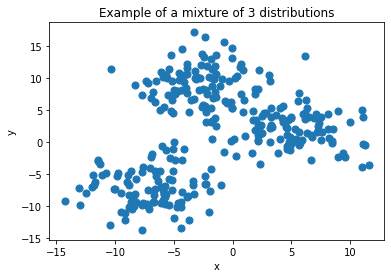

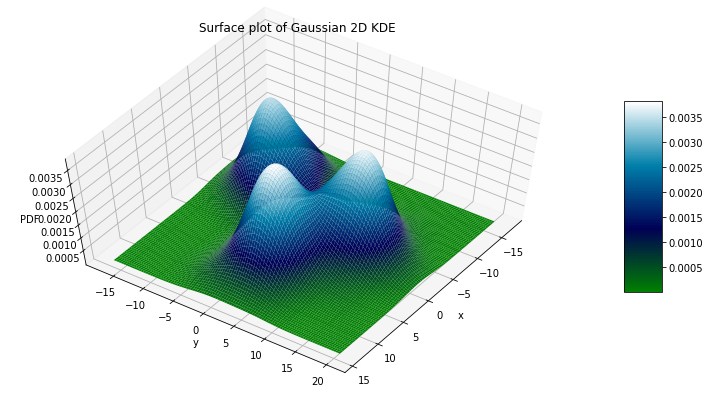

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
# Extract x and y
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

import scipy.stats as st

n_components = 3
X, truth = make_blobs(n_samples=300, centers=n_components,
                      cluster_std = [3, 3, 3],
                      random_state=42)
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.title(f"Example of a mixture of {n_components} distributions")
plt.xlabel("x")
plt.ylabel("y");

x = X[:, 0]
y = X[:, 1]
# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='ocean', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(60, 35)
plt.show()


In [ ]:
pip install picos


     |████████████████████████████████| 307kB 8.8MB/s 
  Created wheel for picos: filename=PICOS-2.2.6-cp37-none-any.whl size=432249 sha256=1891b019f1d9d22c53ca5f7a1e48d43898ec9a8baed982065fc075fb91a80332
  Stored in directory: /root/.cache/pip/wheels/fc/2b/f7/9a4a15051cf3240d4a5b00607db57f18c49801bbf8dcc09d80
Successfully built picos


In [ ]:
pip install pyny3d

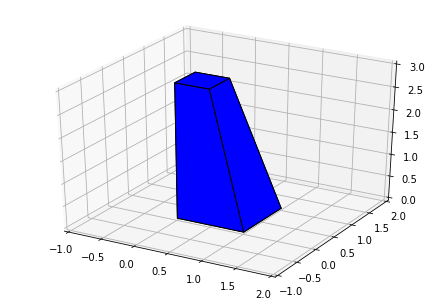

In [ ]:
import numpy as np
import pyny3d.geoms as pyny

poly1 = pyny.Polygon(np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0]]))
poly2 = pyny.Polygon(np.array([[0, 0, 3], [0.5, 0, 3], [0.5, 0.5, 3], [0, 0.5, 3]]))
polyhedron = pyny.Polyhedron.by_two_polygons(poly1, poly2)
polyhedron.plot('b')

In [ ]:
import pypoman
from numpy import array, eye, ones, vstack, zeros

n = 10  # dimension of the original polytope
p = 2   # dimension of the projected polytope

# Original polytope:
# - inequality constraints: \forall i, |x_i| <= 1
# - equality constraint: sum_i x_i = 0
A = vstack([+eye(n), -eye(n)])
b = ones(2 * n)
C = ones(n).reshape((1, n))
d = array([0])
ineq = (A, b)  # A * x <= b
eq = (C, d)    # C * x == d

# Projection is proj(x) = [x_0 x_1]
E = zeros((p, n))
E[0, 0] = 1.
E[1, 1] = 1.
f = zeros(p)
proj = (E, f)  # proj(x) = E * x + f

vertices = pypoman.project_polytope(proj, ineq, eq, method='bretl')

if __name__ == "__main__":   # plot projected polytope
    import pylab
    pylab.ion()
    pylab.figure()
    pypoman.plot_polygon(vertices)

ModuleNotFoundError: ignored

In [ ]:
pip install pypoman

Processing /root/.cache/pip/wheels/a0/69/87/33c6dcb13ac9a624a2ff2447a69970f66f89cc4c842d8f6d86/pypoman-0.5.4-cp37-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8d/b1/5bcf723c08eb1180bb40c753597e6525b90f986ef093ed8e1152887fe1d2/pycddlib-2.1.4.tar.gz
  ERROR: Failed building wheel for pycddlib
  Running setup.py clean for pycddlib
Failed to build pycddlib
    Running setup.py install for pycddlib ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-n1sul2fd/pycddlib/setup.py'"'"'; __file__='"'"'/tmp/pip-install-n1sul2fd/pycddlib/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-qdlok5y8/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


In [ ]:
#https://fresnel.readthedocs.io/en/stable/examples/01-Primitives/04-Polygon-geometry.html
import fresnel
scene = fresnel.Scene()
geometry = fresnel.geometry.Polygon(scene,
                                    N=2,
                                    vertices = [[0, -1], [1, 1],
                                                [0, 0.5], [-1, 1]])
geometry.material.color = fresnel.color.linear([0.20,0.64,0.58])
geometry.material.solid=1
geometry.position[:] = [[-1,0],
                        [1, 0]]
fresnel.preview(scene)

SyntaxError: ignored

In [ ]:
pip install fresnel

  Created wheel for fresnel: filename=fresnel-0.1.1-cp37-none-any.whl size=6015 sha256=2940c575961fc5d90407b7640df13850e6371b58ce75870fd9fb634aa39cc712
  Stored in directory: /root/.cache/pip/wheels/a9/a5/6e/bd000b2c6b0a938835fe71628bba22179760ff2a37f0fa23bb
Successfully built fresnel


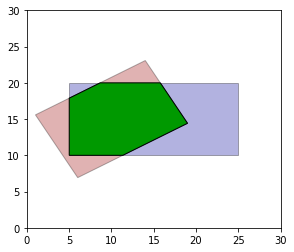

In [ ]:
#from:https://stackoverflow.com/questions/44797713/calculate-the-area-of-intersection-of-two-rotated-rectangles-in-python

import shapely.geometry
import shapely.affinity

class RotatedRect:
    def __init__(self, cx, cy, w, h, angle):
        self.cx = cx
        self.cy = cy
        self.w = w
        self.h = h
        self.angle = angle

    def get_contour(self):
        w = self.w
        h = self.h
        c = shapely.geometry.box(-w/2.0, -h/2.0, w/2.0, h/2.0)
        rc = shapely.affinity.rotate(c, self.angle)
        return shapely.affinity.translate(rc, self.cx, self.cy)

    def intersection(self, other):
        return self.get_contour().intersection(other.get_contour())


r1 = RotatedRect(10, 15, 15, 10, 30)
r2 = RotatedRect(15, 15, 20, 10, 0)

from matplotlib import pyplot
from descartes import PolygonPatch

fig = pyplot.figure(1, figsize=(10, 4))
ax = fig.add_subplot(121)
ax.set_xlim(0, 30)
ax.set_ylim(0, 30)

ax.add_patch(PolygonPatch(r1.get_contour(), fc='#990000', alpha=0.3))
ax.add_patch(PolygonPatch(r2.get_contour(), fc='#000099', alpha=0.3))
ax.add_patch(PolygonPatch(r1.intersection(r2), fc='#009900', alpha=1))

pyplot.show()

In [ ]:
# import Point, Polygon
from sympy import Point, Polygon
from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt

# creating points using Point()
p1, p2, p3, p4 = map(Point, [(0, 0), (1, 0), (5, 1), (0, 1)])
p5, p6, p7 = map(Point, [(3, 2), (1, -1), (0, 2)])
  
# creating polygons using Polygon()
poly1 = Polygon([(0, 0), (1, 0), (5, 1), (0, 1)])
poly2 = Polygon([(3, 2), (1, -1), (0, 2)])
  
# using intersection()
isIntersection = poly1.intersection(poly2)
points =  isIntersection 

from matplotlib import pyplot
from descartes import PolygonPatch

fig = pyplot.figure(1, figsize=(10, 4))
ax = fig.add_subplot(121)
ax.set_xlim(0, 30)
ax.set_ylim(0, 30)

ax.add_patch(PolygonPatch(poly1.get_contour(), fc='#990000', alpha=0.3))
#ax.add_patch(PolygonPatch(poly2.get_contour(), fc='#000099', alpha=0.3))
#PLT.add_patch(PolygonPatch(poly1.intersection(poly2), fc='#009900', alpha=1)) 

#calculate coverage 
x = poly1.intersection(poly2) 
print ('Coverage: ', x,'%')



ValueError: ignored

[[ 0.24581903 -0.96931574]
 [ 0.70978064 -0.70442278]
 [ 0.99996455  0.00841963]
 [ 0.13550444  0.99077674]
 [ 0.13499388 -0.99084643]
 [ 0.81949089 -0.57309221]
 [-0.98648271 -0.16386538]
 [-0.47906403 -0.87777996]
 [-0.94826065  0.3174929 ]
 [ 0.5071011   0.86188658]
 [ 0.99504884 -0.09938717]
 [-0.93322812  0.35928438]
 [ 0.62739932  0.77869769]
 [ 0.27067147 -0.96267178]
 [ 0.74802621 -0.66366918]
 [ 0.96367298  0.267085  ]
 [-0.74024064  0.67234202]
 [-0.71045897 -0.70373863]
 [ 0.99994393 -0.01058902]
 [-0.99042701 -0.13803743]
 [-0.32565155  0.94548986]
 [ 0.02710516 -0.99963259]
 [-0.41451771 -0.91004125]
 [-0.99937223 -0.03542807]
 [-0.19113499  0.98156376]
 [-0.97407507 -0.22622503]
 [ 0.4888544   0.87236539]
 [-0.99541458 -0.09565467]
 [ 0.72497324 -0.68877703]
 [-0.73931267  0.67336229]
 [-0.88593344 -0.46381241]
 [-0.98114202 -0.19328821]
 [ 0.83295308 -0.55334362]
 [-0.91313134  0.4076655 ]
 [-0.98718568 -0.1595758 ]
 [ 0.30491589  0.95237928]
 [-0.64362081 -0.76534453]
 

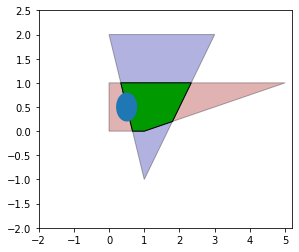

In [ ]:
#from:https://stackoverflow.com/questions/50372135/calculate-overlap-between-polygon-and-shapefile-in-python-3-6?rq=1

#get the intersecting points of constraints 

from scipy.spatial import ConvexHull
#create the polygon: vertices are the intersecting points 
from shapely.geometry import Polygon
import numpy as np
from matplotlib import pyplot as plt

def random_point_circle(x, y,r):
  # random angle
  alpha = 2 * np.pi * np.random.random()
  # vector on that angle
  pt = r*np.array([np.cos(alpha),np.sin(alpha)])
  # Ellipsoidize it
  return pt
 
p1=Polygon([(0, 0), (1, 0), (5, 1), (0, 1)])
p2=Polygon([(3, 2), (1, -1), (0, 2)])
p4 = np.array([random_point_circle(1,1,1) for i in range(100)])
print(np.array([random_point_circle(1,1,1) for i in range(100)]))

p3= p1.intersection(p2)
from matplotlib import pyplot
from descartes import PolygonPatch

fig = plt.figure(1, figsize=(10, 4))
ax = fig.add_subplot(121)
ax.set_xlim(-2, 5.2)
ax.set_ylim(-2, 2.5)

#hull = ConvexHull(p4)
#for simplex in hull.simplices:
    #plt.plot(p4[simplex, 0], p4[simplex, 1], 'k-')

#p5 = hull.intersection(p2)
#p5 = p4.intersection(p1)
#ax.scatter(p4[:,0], p4[:,1],alpha=0.1)

#from: https://www.delftstack.com/howto/matplotlib/how-to-plot-a-circle-in-matplotlib.
draw_circle = plt.Circle((0.5, 0.5), 0.3)
ax.add_artist(draw_circle)
ax.add_patch(PolygonPatch(p1, fc='#990000', alpha=0.3))
ax.add_patch(PolygonPatch(p2, fc='#000099', alpha=0.3))
ax.add_patch(PolygonPatch(p3, fc='#009900', alpha=1))
#ax.add_patch(PolygonPatch(p5, fc='#009900', alpha=0.3))
print(p3) # result: POLYGON ((0.5 0.5, 1 1, 1 0, 0.5 0.5))
print(p3.area) # result: 0.25



In [ ]:
#from: https://stackoverflow.com/questions/55816902/finding-the-intersection-of-two-circles
from __future__ import division
import numpy as np

from math import cos, sin, pi, sqrt, atan2
d2r = pi/180

class Geometry(object):
    def circle_intersection(self, circle1, circle2):
        '''
        @summary: calculates intersection points of two circles
        @param circle1: tuple(x,y,radius)
        @param circle2: tuple(x,y,radius)
        @result: tuple of intersection points (which are (x,y) tuple)
        '''
        # return self.circle_intersection_sympy(circle1,circle2)
        x1,y1,r1 = circle1
        x2,y2,r2 = circle2
        # http://stackoverflow.com/a/3349134/798588
        dx,dy = x2-x1,y2-y1
        d = sqrt(dx*dx+dy*dy)
        if d > r1+r2:
            print("#1")
            return None # no solutions, the circles are separate
        if d < abs(r1-r2):
            print ("#2")
            return None # no solutions because one circle is contained within the other
        if d == 0 and r1 == r2:
            print ("#3")
            return None # circles are coincident and there are an infinite number of solutions

        a = (r1*r1-r2*r2+d*d)/(2*d)
        h = sqrt(r1*r1-a*a)
        xm = x1 + a*dx/d
        ym = y1 + a*dy/d
        xs1 = xm + h*dy/d
        xs2 = xm - h*dy/d
        ys1 = ym - h*dx/d
        ys2 = ym + h*dx/d

        return (xs1,ys1),(xs2,ys2)

    def circle_intersection_sympy(self, circle1, circle2):
        from sympy.geometry import Circle, Point
        x1,y1,r1 = circle1
        x2,y2,r2 = circle2
        c1=Circle(Point(x1,y1),r1)
        c2=Circle(Point(x2,y2),r2)
        intersection = c1.intersection(c2)

        if len(intersection) == 1:
            intersection.append(intersection[0])
        p1 = intersection[0]
        p2 = intersection[1]
        xs1,ys1 = p1.x,p1.y
        xs2,ys2 = p2.x,p2.y
        draw_circle = plt.Circle((0.5, 0.5), 0.3)
        ax.add_artist(draw_circle)
        return (xs1,ys1),(xs2,ys2)

def test_circle_intersection():
    geom = Geometry()
    np.testing.assert_almost_equal(
        geom.circle_intersection((0,0,1),(2,0,1)),
        ((1,0),(1,0)))
    np.testing.assert_almost_equal(
        geom.circle_intersection((2,0,1),(0,0,1)),
        ((1,0),(1,0)))
    np.testing.assert_almost_equal(
        geom.circle_intersection((1,1,1),(3,1,1)),
        ((2,1),(2,1)))
    np.testing.assert_almost_equal(
        geom.circle_intersection((0,0,1),(cos(d2r*45)*2,0,1)),
        ((cos(d2r*45),-sin(d2r*45)),
         (cos(d2r*45),+sin(d2r*45))))


In [ ]:
#from: https://gis.stackexchange.com/questions/187402/how-to-find-the-intersection-areas-of-overlapping-buffer-zones-in-single-shapefi/187499#187499
import itertools


with fiona.open("polygons.shp") as layer:
   rings = [LineString(list(shape(pol['geometry']).exterior.coords)) for pol in layer]
   from shapely.ops import unary_union, polygonize
   union = unary_union(rings)
   result = [geom for geom in polygonize(union)]
   schema=layer.schema.copy()
   schema['properties']['area'] = 'float:10.2'
   with fiona.open('result.shp', 'w', 'ESRI Shapefile', schema) as c:
       for index, pol in enumerate(result):
           c.write({'geometry': mapping(pol),'properties': {'id': index, 'area': pol.area}})

NameError: ignored

In [ ]:
polA = Polygon([(0,0), (3,0), (3,3), (0,3)])
polB = Polygon([(2,-1), (5,-1), (5,2), (2,2)])
polC = Polygon([(5,2), (8,2), (8,5), (5,5)]) 
collection = [polA, polB, polC]

import itertools
for pol in  itertools.combinations(collection, 2):
    print pol[0],pol[1], pol[0].touches(pol[1])
 POLYGON ((0 0, 3 0, 3 3, 0 3, 0 0)) POLYGON ((2 -1, 5 -1, 5 2, 2 2, 2 -1)) False
 POLYGON ((0 0, 3 0, 3 3, 0 3, 0 0)) POLYGON ((5 2, 8 2, 8 5, 5 5, 5 2)) False
 POLYGON ((2 -1, 5 -1, 5 2, 2 2, 2 -1)) POLYGON ((5 2, 8 2, 8 5, 5 5, 5 2)) True

SyntaxError: ignored

In [ ]:
pip install geopandas

     |████████████████████████████████| 1.0MB 7.6MB/s 
     |████████████████████████████████| 6.5MB 34.2MB/s 


In [ ]:
pip install rtree


     |████████████████████████████████| 1.0MB 6.6MB/s 


In [ ]:
pip install fiona


     |████████████████████████████████| 15.3MB 283kB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


TypeError: ignored

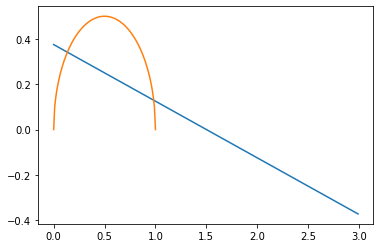

In [ ]:
#!/usr/bin/env python
# Python 2.7.1+

import numpy as np #
import matplotlib.pyplot as plt #

# d is a constant;
d=3
# h is variable; depends on x, which is also variable

# linear function:
# condition for h: d-2x=8h; returns h
def hcond(x):
  return (d-2*x)/8.0

# quadratic function:  
# condition for h: h^2+x^2=d*x ; returns h
def hquad(x):
  return np.sqrt(x-x**2)

# x indices data
xi = np.arange(0,3,0.01)

# function values in respect to x indices data
hc = hcond(xi)
hq = hquad(xi)

fig = plt.figure() 
sp = fig.add_subplot(111)

myplot = sp.plot(xi,hc)
myplot2 = sp.plot(xi,hq)

ax.fill_between(myplot, myplot2,facecolor='gray')

plt.show()

In [ ]:
#intersection area 
#https://scipython.com/book/chapter-8-scipy/problems/p84/overlapping-circles/
import numpy as np
from scipy.optimize import brentq

def intersection_area(d, R, r):
    """Return the area of intersection of two circles.

    The circles have radii R and r, and their centres are separated by d.

    """

    if d <= abs(R-r):
        # One circle is entirely enclosed in the other.
        return np.pi * min(R, r)**2
    if d >= r + R:
        # The circles don't overlap at all.
        return 0

    r2, R2, d2 = r**2, R**2, d**2
    alpha = np.arccos((d2 + r2 - R2) / (2*d*r))
    beta = np.arccos((d2 + R2 - r2) / (2*d*R))
    return ( r2 * alpha + R2 * beta -
             0.5 * (r2 * np.sin(2*alpha) + R2 * np.sin(2*beta))
           )

def find_d(A, R, r):
    """
    Find the distance between the centres of two circles giving overlap area A.

    """

    # A cannot be larger than the area of the smallest circle!
    if A > np.pi * min(r, R)**2:
        raise ValueError("Intersection area can't be larger than the area"
                         " of the smallest circle")
    if A == 0:
        # If the circles don't overlap, place them next to each other
        return R+r

    if A < 0:
        raise ValueError('Negative intersection area')

    def f(d, A, R, r):
        return intersection_area(d, R, r) - A

    a, b = abs(R-r), R+r
    d = brentq(f, a, b, args=(A, R, r))
    return d

In [ ]:
import numpy as np
from scipy.optimize import brentq

In [x]: find_d(0.35, 1, 0.4))

def intersection_area(d, R, r):
    """Return the area of intersection of two circles.

    The circles have radii R and r, and their centres are separated by d.

    """

    if d <= abs(R-r):
        # One circle is entirely enclosed in the other.
        return np.pi * min(R, r)**2
    if d >= r + R:
        # The circles don't overlap at all.
        return 0

    r2, R2, d2 = r**2, R**2, d**2
    alpha = np.arccos((d2 + r2 - R2) / (2*d*r))
    beta = np.arccos((d2 + R2 - r2) / (2*d*R))
    return ( r2 * alpha + R2 * beta -
             0.5 * (r2 * np.sin(2*alpha) + R2 * np.sin(2*beta))
           )

def find_d(A, R, r):
    """
    Find the distance between the centres of two circles giving overlap area A.

    """

    # A cannot be larger than the area of the smallest circle!
    if A > np.pi * min(r, R)**2:
        raise ValueError("Intersection area can't be larger than the area"
                         " of the smallest circle")
    if A == 0:
        # If the circles don't overlap, place them next to each other
        return R+r

    if A < 0:
        raise ValueError('Negative intersection area')

    def f(d, A, R, r):
        return intersection_area(d, R, r) - A

    a, b = abs(R-r), R+r
    d = brentq(f, a, b, args=(A, R, r))
    return d



SyntaxError: ignored

In [ ]:
pip install quadprog

     |████████████████████████████████| 276kB 5.9MB/s 
  Created wheel for quadprog: filename=quadprog-0.1.8-cp37-cp37m-linux_x86_64.whl size=336655 sha256=294300496397ad9965632b27f27b5a8791e9cd6cfc1aa170d3c007a41de8d64e
  Stored in directory: /root/.cache/pip/wheels/0c/39/5f/c712b0e462439dec9b30080cf34622f167929b39bd964d8baf
Successfully built quadprog


[0.4472136]
[-2.64372813e-10 -5.61449853e-17]
-2.6437281282842333e-10


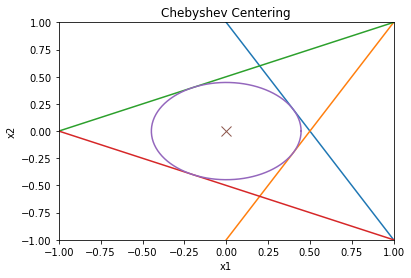

In [ ]:
from __future__ import division

import cvxopt
import numpy as np
from pylab import *
import math

# from cvxpy import numpy as my_numpy

from cvxpy import *

# Taken from CVX website http://cvxr.com/cvx/examples/
# Example: Compute and display the Chebyshev center of a 2D polyhedron
# Ported from cvx matlab to cvxpy by Misrab Faizullah-Khan
# Original comments below

# Boyd & Vandenberghe, "Convex Optimization"
# Joelle Skaf - 08/16/05
# (a figure is generated)
#
# The goal is to find the largest Euclidean ball (i.e. its center and
# radius) that lies in a polyhedron described by linear inequalities in this
# fashion: P = { x : a_i'*x <= b_i, i=1,...,m } where x is in R^2

# Create the problem

# variables
radius = Variable(1)
center = Variable(2)

# constraints
a1 = cvxopt.matrix([2,1], (2,1))
a2 = cvxopt.matrix([2,-1], (2,1))
a3 = cvxopt.matrix([-1,2], (2,1))
a4 = cvxopt.matrix([-1,-2], (2,1))

b = cvxopt.matrix(1, (4,1))


constraints = [ a1.T*center + np.linalg.norm(a1, 2)*radius <= b[0],
				a2.T*center + np.linalg.norm(a2, 2)*radius <= b[1],
				a3.T*center + np.linalg.norm(a3, 2)*radius <= b[2],
				a4.T*center + np.linalg.norm(a4, 2)*radius <= b[3] ]


# objective
objective = Maximize(radius)

p = Problem(objective, constraints)
# The optimal objective is returned by p.solve().
result = p.solve()
# The optimal value
print(radius.value)
print(center.value)
# Convert to 1D array.
print(center.value[0])
#center_val = np.asarray(center.value[:,0])


# Now let's plot it
x = np.linspace(-2, 2, 256,endpoint=True)
theta = np.linspace(0,2*np.pi,100)

# plot the constraints
plot( x, -x*a1[0]/a1[1] + b[0]/a1[1])
plot( x, -x*a2[0]/a2[1] + b[0]/a2[1])
plot( x, -x*a3[0]/a3[1] + b[0]/a3[1])
plot( x, -x*a4[0]/a4[1] + b[0]/a4[1])


# plot the solution
plot( center.value[0] + radius.value*cos(theta), center.value[1] + radius.value*sin(theta) )
plot( center.value[0], center.value[1], 'x', markersize=10 )

# label
title('Chebyshev Centering')
xlabel('x1')
ylabel('x2')

axis([-1, 1, -1, 1])

show()

In [ ]:
# Import packages.
import cvxpy as cp
import numpy as np

# Generate a random SDP.
n = 3
p = 3
np.random.seed(1)
C = np.random.randn(n, n)
A = []
b = []
for i in range(p):
    A.append(np.random.randn(n, n))
    b.append(np.random.randn())

# Define and solve the CVXPY problem.
# Create a symmetric matrix variable.
X = cp.Variable((n,n), symmetric=True)
# The operator >> denotes matrix inequality.
constraints = [X >> 0]
constraints += [
    cp.trace(A[i] @ X) == b[i] for i in range(p)
]
prob = cp.Problem(cp.Minimize(cp.trace(C @ X)),
                  constraints)
prob.solve()

# Print result.
print("The optimal value is", prob.value)
print("A solution X is")
print(X.value)

The optimal value is 2.654351510231607
A solution X is
[[ 1.60806 -0.5977  -0.69576]
 [-0.5977   0.22229  0.24689]
 [-0.69576  0.24689  1.3968 ]]


TypeError: ignored

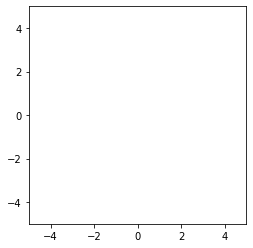

In [ ]:
from matplotlib import pyplot as plt
from shapely.geometry.point import Point
from shapely import affinity
from matplotlib.patches import Polygon
import numpy as np

def create_ellipse(center, lengths, angle=0):
    circ = Point(center).buffer(1)
    ell = affinity.scale(circ, int(lengths[0]), int(lengths[1]))
    ellr = affinity.rotate(ell, angle)
    return ellr

fig,ax = plt.subplots()

##these next few lines are pretty important because
##otherwise your ellipses might only be displayed partly
##or may be distorted
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
ax.set_aspect('equal')

##first ellipse in blue
ellipse1 = create_ellipse((0,0),(2,4),10)
verts1 = np.array(ellipse1.exterior.coords.xy)
patch1 = Polygon(verts1.T, color = 'blue', alpha = 0.5)
ax.add_patch(patch1)

##second ellipse in red    
ellipse2 = create_ellipse((1,-1),(3,2),50)
verts2 = np.array(ellipse2.exterior.coords.xy)
patch2 = Polygon(verts2.T,color = 'red', alpha = 0.5)
ax.add_patch(patch2)

##the intersect will be outlined in black
intersect = ellipse1.intersection(ellipse2)
verts3 = np.array(intersect.exterior.coords.xy)
patch3 = Polygon(verts3.T, facecolor = 'none', edgecolor = 'black')
ax.add_patch(patch3)

##compute areas and ratios 
print('area of ellipse 1:',ellipse1.area)
print('area of ellipse 2:',ellipse2.area)
print('area of intersect:',intersect.area)
print('intersect/ellipse1:', intersect.area/ellipse1.area)
print('intersect/ellipse2:', intersect.area/ellipse2.area)


plt.show()

In [ ]:
pip install shapely


Single polytope 
  [] x <= []



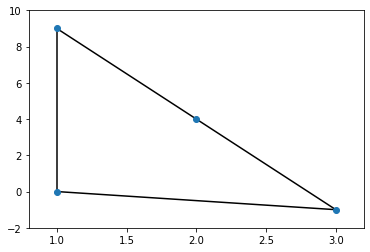

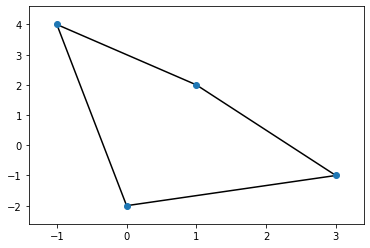

In [ ]:
# Using numpy to create matrices
import numpy as np 
import polytope as pc 
import scipy.spatial

# Declaring numpy arrays
A = np.array([[1.0,  2.0],
              [3.0, -1.0],
              [-1.0, 4.0],
              [0.0, -2.0]])
  
b = np.array([2.0, 0.0, 3.0, 1.0])
  
C = np.array([[1.0,  0.0],
              [2.0,  4.0],
              [3.0, -1.0],
              [1.0,  9.0]]) 
  
d = np.array([2.0, 0.0, -1.0, 3.0])
  
p1 = pc.Polytope(A, b)
p2 = pc.Polytope(C, d)
  
# Using diff method
P0 = p1.diff(p2)
print(P0)

import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial

V = [
    np.array([0, 0]), 
    np.array([1 / 2, 0]), 
    np.array([1 / 2, 1 / 4]), 
    np.array([0, 1 / 3])
]
P = scipy.spatial.ConvexHull(C)
scipy.spatial.convex_hull_plot_2d(P);
Q = scipy.spatial.ConvexHull(A)
scipy.spatial.convex_hull_plot_2d(Q);

NameError: ignored

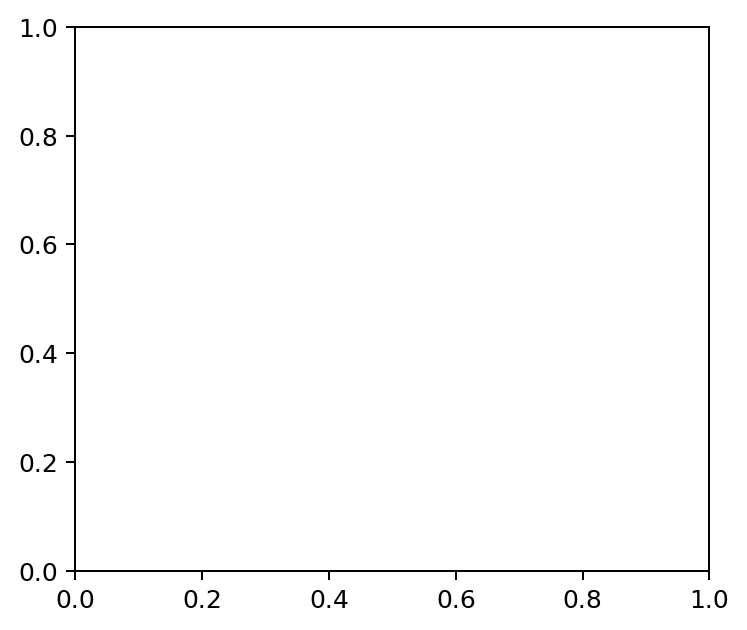

In [ ]:
#from:https://shapely.readthedocs.io/en/stable/manual.html

from matplotlib import pyplot
from matplotlib.patches import Circle
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
from shapely.geometry import LineString
import numpy as np
#from shapely.figures import SIZE, BLUE, GRAY, set_limits
#from figures import BLUE, SIZE, set_limits, plot_coords, color_isvalid
BLUE = '#6699cc'    

fig = pyplot.figure(1, figsize=(10, 4), dpi=180)
# 3: invalid polygon, ring touch along a line
ax = fig.add_subplot(121)

ext = [(0, 0), (0, 2), (2, 2), (2, 0), (0, 0)]
int = [(0.5, 0), (1.5, 0), (1.5, 1), (0.5, 1), (0.5, 0)]
polygon = Polygon(ext, [int])

plot_coords(ax, polygon.interiors[0])
plot_coords(ax, polygon.exterior)

patch = PolygonPatch(polygon, facecolor=color_isvalid(polygon), edgecolor=color_isvalid(polygon, valid=BLUE), alpha=0.5, zorder=2)
ax.add_patch(patch)

ax.set_title('c) invalid')

set_limits(ax, -1, 3, -1, 3)

#4: invalid self-touching ring
ax = fig.add_subplot(122)
ext = [(0, 0), (0, 2), (2, 2), (2, 0), (0, 0)]
int_1 = [(0.5, 0.25), (1.5, 0.25), (1.5, 1.25), (0.5, 1.25), (0.5, 0.25)]
int_2 = [(0.5, 1.25), (1, 1.25), (1, 1.75), (0.5, 1.75)]
# int_2 = [
polygon = Polygon(ext, [int_1, int_2])

plot_coords(ax, polygon.interiors[0])
plot_coords(ax, polygon.interiors[1])
plot_coords(ax, polygon.exterior)

patch = PolygonPatch(polygon, facecolor=color_isvalid(polygon), edgecolor=color_isvalid(polygon, valid=BLUE), alpha=0.5, zorder=2)
ax.add_patch(patch)

ax.set_title('d) invalid')

set_limits(ax, -1, 3, -1, 3)

pyplot.show()


In [ ]:
#from: https://github.com/scikit-geometry/scikit-geometry/blob/master/docs/source/polygon.ipynb
import numpy as np 
import polytope as pc 
  
  
# Declaring numpy arrays
A = np.array([[1.0,  2.0],
              [3.0, -1.0],
              [-1.0, 4.0],
              [0.0, -2.0]])
  
b = np.array([2.0, 0.0, 3.0, 1.0])
  
C = np.array([[1.0,  0.0],
              [2.0,  4.0],
              [3.0, -1.0],
              [1.0,  9.0]]) 
  
d = np.array([2.0, 0.0, -1.0, 3.0])
  
p1 = pc.Polytope(A, b)
p2 = pc.Polytope(C, d)
r =  pc.Region([p1, p2])
for polytope in r:
    print(polytope)

Single polytope 
  [[ 0.44721  0.89443] |    [[0.89443]
   [ 0.94868 -0.31623] x <=  [0.     ]
   [-0.24254  0.97014] |     [0.72761]
   [ 0.      -1.     ]]|     [0.5    ]]

Single polytope 
  [[ 1.       0.     ] |    [[ 2.     ]
   [ 0.44721  0.89443] x <=  [ 0.     ]
   [ 0.94868 -0.31623] |     [-0.31623]
   [ 0.11043  0.99388]]|     [ 0.33129]]



In [ ]:
pip install scikit.geometry

ERROR: Could not find a version that satisfies the requirement scikit.geometry (from versions: none)
ERROR: No matching distribution found for scikit.geometry


In [ ]:
pip install python-figures

  Created wheel for python-figures: filename=python_figures-1.1-cp37-none-any.whl size=4180 sha256=79a1a4fc6c0b1df01062aa94914f347153cd4e77be718a270601dce1429a178f
  Stored in directory: /root/.cache/pip/wheels/8d/12/1f/6fae5959cfbc6c9d92242565d28ca376938a167b7f09742bf0
Successfully built python-figures


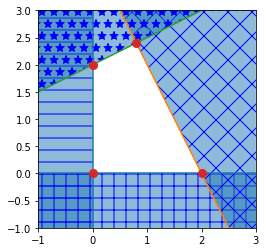

In [ ]:
#from:https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.HalfspaceIntersection.html
from scipy.optimize import linprog
from matplotlib.patches import Circle
from scipy.spatial import HalfspaceIntersection
halfspaces = np.array([[-1, 0., 0.],
                       [0., -1., 0.],
                       [2., 1., -4.],
                       [-0.5, 1., -2.]])
feasible_point = np.array([0.5, 0.5])
hs = HalfspaceIntersection(halfspaces, feasible_point)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
xlim, ylim = (-1, 3), (-1, 3)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
x = np.linspace(-1, 3, 100)
symbols = ['-', '+', 'x', '*']
signs = [0, 0, -1, -1]
fmt = {"color": None, "edgecolor": "b", "alpha": 0.5}
for h, sym, sign in zip(halfspaces, symbols, signs):
    hlist = h.tolist()
    fmt["hatch"] = sym
    if h[1]== 0:
        ax.axvline(-h[2]/h[0], label='{}x+{}y+{}=0'.format(*hlist))
        xi = np.linspace(xlim[sign], -h[2]/h[0], 100)
        ax.fill_between(xi, ylim[0], ylim[1], **fmt)
    else:
        ax.plot(x, (-h[2]-h[0]*x)/h[1], label='{}x+{}y+{}=0'.format(*hlist))
        ax.fill_between(x, (-h[2]-h[0]*x)/h[1], ylim[sign], **fmt)
x, y = zip(*hs.intersections)
ax.plot(x, y, 'o', markersize=8)



In [ ]:
pip install polytope


     |████████████████████████████████| 51kB 2.6MB/s 
  Created wheel for polytope: filename=polytope-0.2.3-cp37-none-any.whl size=46039 sha256=ce78e017871fccd58317253fe140b4469ef86748bb1f18070860d6999735c01f
  Stored in directory: /root/.cache/pip/wheels/4b/76/87/b482ea393100791e303f38cad0e8283b5a0062f9c109934054
Successfully built polytope


In [ ]:
import numpy as np
from scipy.spatial import ConvexHull, convex_hull_plot_2d
points = np.random.rand(30, 2)   # 30 random points in 2-D
hull = ConvexHull(points)
hull2 = ConvexHull(points)
hull3= hull-hull2
import matplotlib.pyplot as plt
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull3.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

TypeError: ignored

In [ ]:
pip install localization


In [ ]:
import localization as lx
P=lx.Project(mode='2D',solver='LSE')
P.add_anchor('anchore_A',(0,100))
P.add_anchor('anchore_B',(100,100))
P.add_anchor('anchore_C',(100,0))
t,label=P.add_target()
t.add_measure('anchore_A',50)
t.add_measure('anchore_B',50)
t.add_measure('anchore_C',50)
P.solve()  # Then the target location is:  
print(t.loc)

LSE Geolocating...
p(59.103629855759586,59.10363763568137,0.0)


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import gym
import time
from enviroment import Env_cellular as env
import matplotlib.pyplot as plt

#####################  hyper parameters  ####################
Pn = 1
K=2

MAX_EPISODES = 400
MAX_EP_STEPS = 100
LR_A = 0.002    # learning rate for actor
LR_C = 0.004    # learning rate for critic
GAMMA = 0.9     # reward discount
TAU = 0.01      # soft replacement
MEMORY_CAPACITY = 10000
BATCH_SIZE = 32

###############################  DDPG  ####################################
class DDPG(object):
    def __init__(self, a_dim, s_dim, a_bound,):
        self.memory = np.zeros((MEMORY_CAPACITY, s_dim * 2 + a_dim + 1), dtype=np.float32)
        self.pointer = 0
        self.sess = tf.Session()


        self.a_dim, self.s_dim, self.a_bound = a_dim, s_dim, a_bound,
        self.S = tf.placeholder(tf.float32, [None, s_dim], 's')
        self.S_ = tf.placeholder(tf.float32, [None, s_dim], 's_')
        self.R = tf.placeholder(tf.float32, [None, 1], 'r')

        self.a = self._build_a(self.S,)
        q = self._build_c(self.S, self.a, )
        a_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Actor')
        c_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Critic')
        ema = tf.train.ExponentialMovingAverage(decay=1 - TAU)          # soft replacement

        def ema_getter(getter, name, *args, **kwargs):
            return ema.average(getter(name, *args, **kwargs))

        target_update = [ema.apply(a_params), ema.apply(c_params)]      # soft update operation
        a_ = self._build_a(self.S_, reuse=True, custom_getter=ema_getter)   # replaced target parameters
        q_ = self._build_c(self.S_, a_, reuse=True, custom_getter=ema_getter)

        a_loss = - tf.reduce_mean(q)  # maximize the q
        self.atrain = tf.train.AdamOptimizer(LR_A).minimize(a_loss, var_list=a_params)

        with tf.control_dependencies(target_update):    # soft replacement happened at here
            q_target = self.R + GAMMA * q_
            td_error = tf.losses.mean_squared_error(labels=q_target, predictions=q)
            self.ctrain = tf.train.AdamOptimizer(LR_C).minimize(td_error, var_list=c_params)

        self.sess.run(tf.global_variables_initializer())

    def choose_action(self, s):
        return self.sess.run(self.a, {self.S: s })[0]

    def learn(self):
        indices = np.random.choice(min(MEMORY_CAPACITY,self.pointer), size=BATCH_SIZE)
        bt = self.memory[indices, :]
        bs = bt[:, :self.s_dim]
        ba = bt[:, self.s_dim: self.s_dim + self.a_dim]
        br = bt[:, -self.s_dim - 1: -self.s_dim]
        bs_ = bt[:, -self.s_dim:]

        self.sess.run(self.atrain, {self.S: bs})
        self.sess.run(self.ctrain, {self.S: bs, self.a: ba, self.R: br, self.S_: bs_})

    def store_transition(self, s, a, r, s_):
        r = np.reshape(r,(1,1))
        a = np.reshape(a,(1,1))
        #print(f"state is {s}, action is {a}, reward is {r}, next state is {s_}")
        transition = np.hstack((s, a, r, s_))
        index = self.pointer % MEMORY_CAPACITY  # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1

    def _build_a(self, s, reuse=None, custom_getter=None):
        trainable = True if reuse is None else False
        with tf.variable_scope('Actor', reuse=reuse, custom_getter=custom_getter):
            net = tf.layers.dense(s, 64, activation=tf.nn.relu, name='l1', trainable=trainable)
            a2 = tf.layers.dense(net, 64, activation=tf.nn.tanh, name='l2', trainable=trainable)
            #a3 = tf.layers.dense(a2, 30, activation=tf.nn.tanh, name='l3', trainable=trainable)

            a = tf.layers.dense(a2, self.a_dim, activation=tf.nn.tanh, name='a', trainable=trainable)
            return tf.multiply(a, self.a_bound, name='scaled_a')

    def _build_c(self, s, a, reuse=None, custom_getter=None):
        trainable = True if reuse is None else False
        with tf.variable_scope('Critic', reuse=reuse, custom_getter=custom_getter):
            n_l1 = 64
            w1_s = tf.get_variable('w1_s', [self.s_dim, n_l1], trainable=trainable)
            w1_a = tf.get_variable('w1_a', [self.a_dim, n_l1], trainable=trainable)
            b1 = tf.get_variable('b1', [1, n_l1], trainable=trainable)
            net = tf.nn.relu(tf.matmul(s, w1_s) + tf.matmul(a, w1_a) + b1)
            net2 = tf.layers.dense(net, 64, activation=tf.nn.relu, name='lx2', trainable=trainable)
            #net3 = tf.layers.dense(net2, 30, activation=tf.nn.relu, name='lx3', trainable=trainable)

            #not sure about this part
            return tf.layers.dense(net2, 1, trainable=trainable)  # Q(s,a)


###############################  training  ####################################



s_dim = 3# dimsion of states
a_dim = 1# dimension of action
a_bound = 1 #bound of action
state_am = 1000


location_vector = np.array([[0, 1],[0,1000]]) #locations of GB users


location_GF = np.array([[1,1]])# np.ones((1, 2))

##### fading for GB user
hnx1 = np.random.randn(K, 2)
hnx2 = np.random.randn(K, 2)
fading_n = 1#hnx1 ** 2 + hnx2 ** 2
#### fading for GF user
h0x1 = np.random.randn(1, 1)
h0x2 = np.random.randn(1, 1)
fading_0 = 1#h0x1[0,0] ** 2 + h0x2[0,0] ** 2


myenv = env( MAX_EP_STEPS, s_dim, location_vector,location_GF,K,Pn, fading_n, fading_0)
#myenv = env(P0, MAX_EP_STEPS, s_dim, location_vector,location_GF,K)

#myenv = env(P0,MAX_EP_STEPS,s_dim)

ddpg = DDPG(a_dim, s_dim, a_bound)

var = 1  # control exploration
t1 = time.time()
ep_rewardall = []
ep_rewardall_greedy = []
ep_rewardall_random = []
for i in range(MAX_EPISODES):
    batter_ini = myenv.reset()
    s = myenv.channel_sequence[i%myenv.K,:].tolist() #the current GB user, 2 element [GB-GF, GB-BS]
    #s.append(myenv.h0)
    s.append(batter_ini)
    s = np.reshape(s,(1,s_dim))
    s = s*state_am #amplify the state
    s_greedy = s
    s_random = s
    #print(s[0,0:2])
    ep_reward = 0
    ep_reward_random = 0
    ep_reward_greedy = 0
    s_traj = []
    s_traj_random = []
    s_traj_greedy = []
    for j in range(MAX_EP_STEPS):

        # Add exploration noise
        a = ddpg.choose_action(s)
        #print(s)
        a = np.clip(np.random.normal(a, var), 0, 1)    # add randomness to action selection for exploration
        #print(myenv.location)
        r, s_, done = myenv.step(a,s/state_am,j)
        s_ = s_*state_am
        s_traj.append(s_)
        ddpg.store_transition(s, a, r, s_)

        if var > 0.1:
            var *= .9998  # decay the action randomness
        ddpg.learn()

        s = s_
        ep_reward += r

        ##### greedy
        r_greedy, s_next_greedy, done = myenv.step_greedy(s_greedy/state_am, j)
        s_traj_greedy.append(s_next_greedy)
        s_greedy = s_next_greedy*state_am
        ep_reward_greedy += r_greedy

        ##### random
        r_random, s_next_random, done = myenv.step_random(s_random/state_am, j)
        s_traj_random.append(s_next_random)
        s_random = s_next_random*state_am
        ep_reward_random += r_random


        if j == MAX_EP_STEPS-1:
            #print(f"Episode: {i}, reward is {ep_reward}, and Explore is {var}")
            print('Episode:', i, ' Reward: %i' % int(ep_reward),' Reward Greedy: %i' % int(ep_reward_greedy),' Reward random: %i' % int(ep_reward_random), 'Explore: %.2f' % var )
            #print(myenv.location)
            # if ep_reward > -300:RENDER = True
            break
    ep_reward = np.reshape(ep_reward/MAX_EP_STEPS, (1,))
    ep_rewardall.append(ep_reward)

    ep_reward_greedy = np.reshape(ep_reward_greedy/MAX_EP_STEPS, (1,))
    ep_rewardall_greedy.append(ep_reward_greedy)

    ep_reward_random = np.reshape(ep_reward_random/MAX_EP_STEPS, (1,))
    ep_rewardall_random.append(ep_reward_random)

#print(s_)
print('Running time: ', time.time() - t1)

print(f"{myenv.hn} and {myenv.h0}")
plt.plot(ep_rewardall, "^-", label='DDPG: rewards')
plt.plot(ep_rewardall_greedy, "+:", label='Greedy: rewards')
plt.plot(ep_rewardall_random, "o--", label='Random: rewards')
plt.xlabel("Episode")
plt.ylabel(" Epsiodic Reward -  Data Rate (NPCU)")
plt.legend()
plt.show()

''' Save final results'''

Instructions for updating:
non-resource variables are not supported in the long term


ModuleNotFoundError: ignored

In [ ]:
from ortools.sat.python import cp_model


def SimpleSatProgram():
    """Minimal CP-SAT example to showcase calling the solver."""
    # Creates the model.
    model = cp_model.CpModel()

    # Creates the variables.
    num_vals = 3
    x = model.NewIntVar(0, num_vals - 1, 'x')
    y = model.NewIntVar(0, num_vals - 1, 'y')
    z = model.NewIntVar(0, num_vals - 1, 'z')

    # Creates the constraints.
    model.Add(x != y)

    # Creates a solver and solves the model.
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL:
        print('x = %i' % solver.Value(x))
        print('y = %i' % solver.Value(y))
        print('z = %i' % solver.Value(z))


SimpleSatProgram()

x = 1
y = 0
z = 0


In [ ]:
pip install ortools


     |████████████████████████████████| 14.2MB 260kB/s 
     |████████████████████████████████| 1.0MB 52.5MB/s 
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


In [ ]:
pip install csp


  Created wheel for csp: filename=csp-0.1a10-cp37-none-any.whl size=9851 sha256=8695847c69bc43bfe4489370d8d7bc10d645bbffd0fdfe07a07ea47aadad8860
  Stored in directory: /root/.cache/pip/wheels/4e/d6/34/256c63e233768f06cdbc3dfe3e46627449eff4691d41430244
Successfully built csp


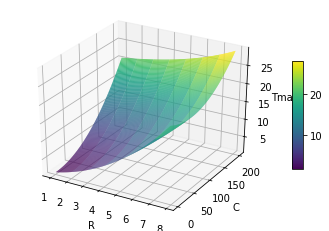

In [ ]:
# reference : https://xavierbourretsicotte.github.io/Intro_optimization.html

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
# if using a Jupyter notebook, include:
import matplotlib
from scipy import special
from matplotlib import cm, colors

def Rosenbrock(x,y):
    return 0.25*((1 + x)**2 + 0.002*(y - x**2)**2)

# y : R
# x : congestion

x = np.arange(1,8,0.1)
y = np.arange(1,200,0.1)
X, Y = np.meshgrid(x, y)
Z = Rosenbrock(X, Y)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, (Z), rstride=10, cstride=10, cmap=cm.viridis)
#ax.plot(iter_x,iter_y, Rosenbrock(iter_x,iter_y),color = 'r', marker = '*', alpha = .4)


ax.set_xlabel('R')
ax.set_ylabel('C')
ax.set_zlabel('Tmax')

fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


#Contour plot
#ax = fig.add_subplot(1, 2, 2)
#ax.contour(X,Y,Z, 50, cmap = 'jet')
#Plotting the iterations and intermediate values
#ax.scatter(iter_x,iter_y,color = 'r', marker = '*')
#ax.quiver(iter_x[:-1], iter_y[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .3)
#ax.set_title('Gradient Descent with {} iterations'.format(len(iter_count)))


plt.show()

<Figure size 720x1080 with 0 Axes>

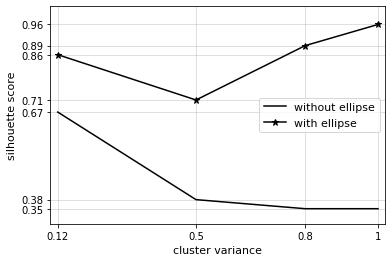

In [ ]:
#1e5phones_12_cluster
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from matplotlib.ticker import AutoMinorLocator

#data
noc = (0.12,0.5,0.8,1)
success_rate_wt = (0.67,0.38,0.35,0.35)
success_rate = (0.86,0.71,0.89,0.96)
arrayY = (0.35,0.38,0.67,0.71,0.86,0.89,0.96)

#put labels to all data points
# Create a subplots and twin axes
plt.figure(figsize=(10, 15))
f, ax1 = plt.subplots()

#limits
ax1.set_ylim(0.3,1.02)
ax1.set_xlim(0.1,1.02)
ax1.grid(color='gray', alpha=0.5, linewidth=0.5)

ax1.set_xticks(noc)
ax1.set_xticklabels([0.12,0.5,0.8,1], fontsize=10)
ax1.set_yticks(arrayY)
ax1.set_yticklabels([0.35,0.38,0.67,0.71,0.86,0.89,0.96],fontsize=10)

#legend
lns1 = ax1.plot(noc, success_rate_wt, color="black", label='without ellipse')
lns2 = ax1.plot(noc, success_rate, color="black", marker="*", markersize=7, label='with ellipse')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=7, fontsize=11)

#labels
ax1.set_xlabel("cluster variance",fontsize=11)
ax1.set_ylabel(r"silhouette score",fontsize=11)
plt.savefig("first.pdf")
plt.show()

In [ ]:
pip install SimpleITK 

     |████████████████████████████████| 47.4MB 78kB/s 


In [ ]:
pip install gap-stat

In [ ]:
pip install gapstat_rs

     |████████████████████████████████| 819kB 7.3MB/s 


d:  [2 3]
Optimal value: -0.5189340871101441


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


centroids 2d:  [[0.52355258 1.01141462]
 [0.66537437 2.33516215]
 [2.01355298 2.01462632]]
Optimal clusters:  4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


silhouette_score kmeans 0.5546076500050192


<Figure size 432x288 with 0 Axes>

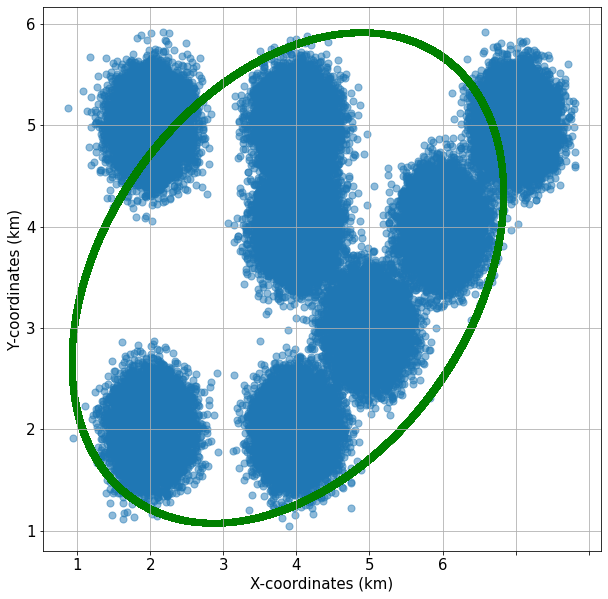

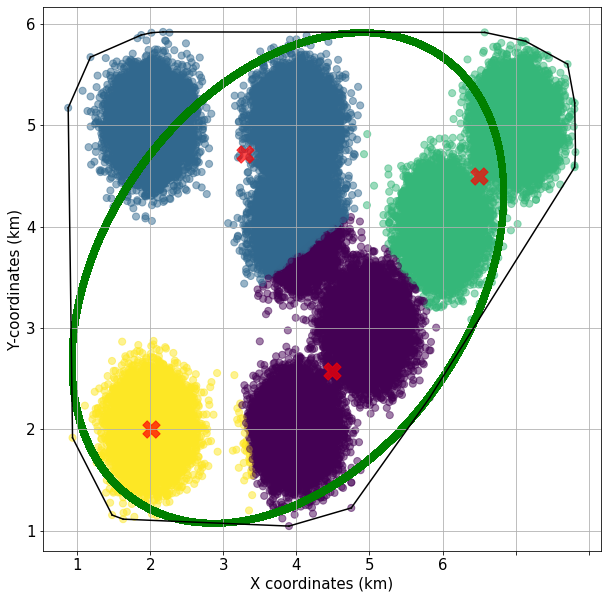

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:118: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


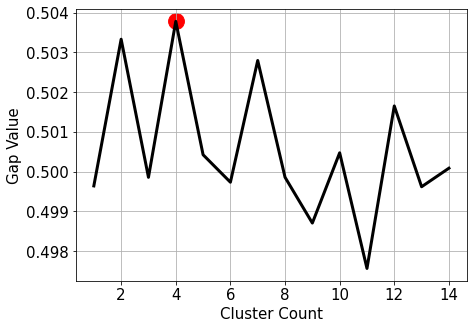

NameError: ignored

In [ ]:
from mpl_toolkits.mplot3d import axes3d
from scipy.spatial import ConvexHull
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_blobs
from collections import Counter
import math
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.decomposition import PCA
from gap_statistic import OptimalK
from numpy import linalg as LA
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics
np.random.seed(0)

#https://stackoverflow.com/questions/61859098/maximum-volume-inscribed-ellipsoid-in-a-polytope-set-of-points?fbclid=IwAR2DcaQSvqd368lstBayY-atAbQxCVa_EecgS7HE-mrpK6EanO9qbsX2Drg
#From: https://stackoverflow.com/a/61786434/752843

def random_point_ellipse(W,d):
  # random angle
  alpha = 2 * np.pi * np.random.random()
  # vector on that angle
  pt = np.array([np.cos(alpha),np.sin(alpha)])
  # Ellipsoidize it
  return W@pt+d

def GetRandom(dims, Npts):
  if dims==2:
    np.random.seed(0)
    W = sklearn.datasets.make_spd_matrix(2)
    d = np.array([2,3])
    print("d: ",d)
    #form clusters 2d 
    centers = [[0, 1], [1.5, 1.5], [1,1],[1,2],[2,2],[2.5,2.5],[0,2.5],[1,2.5]]
    stds=[0.12, 0.12,0.12,0.12,0.12,0.12,0.12,0.12]
    points, labels_true = make_blobs(n_samples=100000, centers=centers, cluster_std=stds, random_state=0)
  return points

def GetHull(points):
  dim  = points.shape[1]
  hull = ConvexHull(points)
  A    = hull.equations[:,0:dim]
  b    = hull.equations[:,dim]
  return A, -b, hull #Negative moves b to the RHS of the inequality

def Plot(points, hull, B, d):
  fig = plt.figure()
  if points.shape[1]==2:
    np.random.seed(0)
    #kmeans_model = KMeans(n_clusters=K).fit(points)
    kmeans_model = KMeans(n_clusters=3,init='k-means++', n_init=10)
    kmeans = kmeans_model.fit(points)
    centers = np.array(kmeans.cluster_centers_)
    fig = plt.figure(figsize = (10, 10)) 
    plt.grid(True)
    ax = fig.add_subplot(111)
    #mycolours = ["red", "green", "blue"]
    #col = [mycolours[i] for i in labels_true]
    ax.scatter(points[:,0], points[:,1],s=50,alpha=0.5)
    #ax.scatter(points[:,0], points[:,1],c=kmeans.labels_.astype(float),s=50,cmap='viridis',alpha=0.5)
    #ax.scatter(centers[:,0], centers[:,1], c = 'r', marker ='X',s=300,alpha=1) 
    # Centroid coordinates
    centroids = kmeans.cluster_centers_
    print("centroids 2d: ",centroids)
    #for simplex in hull.simplices:
      #plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    display_points = np.array([random_point_ellipse([[1,0],[0,1]],[0,0]) for i in range(100000)])
    display_points = display_points@B+d
    ax.scatter(display_points[:,0], display_points[:,1],c='green',alpha=0.7)
    #ax.set_ylim(-0.6,3.0)
    #ax.set_xlim(-1.5,3.2)
    ax.set_xticklabels([0,1,2,3,4,5,6],fontsize=15)
    ax.set_yticklabels([0,1,2,3,4,5,6,7],fontsize=15)
    ax.set_xlabel('X-coordinates (km)',fontsize=15)
    ax.set_ylabel('Y-coordinates (km)',fontsize=15)
    
    #optimal clustering
    np.random.seed(0)
    optimalK = OptimalK(parallel_backend='rust')
    n_clusters = optimalK(points, cluster_array=np.arange(1, 15))
    print('Optimal clusters: ', n_clusters)

    #plot
    fig = plt.figure(figsize = (10, 10)) 
    plt.grid(True)
    ax1 = fig.add_subplot(111)
    #n_clusters = optimalK(points, cluster_array=np.arange(1, 15))
    #print('Optimal clusters: ', n_clusters)
    np.random.seed(42)
    optimalK.gap_df.head()
    km = KMeans(n_clusters,init='k-means++', n_init=10)
    km.fit(points)
    y_cluster_kmeans = km.predict(points)
    #score kmeans 
    #score = adjusted_rand_score(labels_true, y_cluster_kmeans)
    #print("score kmeans: ",score)
    score2 = metrics.silhouette_score(points, y_cluster_kmeans)
    print("silhouette_score kmeans",score2)

    ax1.scatter(points[:,0], points[:,1],c=km.labels_.astype(float),s=50,cmap='viridis',alpha=0.5)
    plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], c='r',marker ='X', s=300, alpha=0.7)
    for simplex in hull.simplices:
      plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    ax1.scatter(display_points[:,0], display_points[:,1],c='green',alpha=0.7)
    ax1.set_xticklabels([0,1,2,3,4,5,6],fontsize=15)
    ax1.set_yticklabels([0,1,2,3,4,5,6,7],fontsize=15)
    ax1.set_xlabel('X coordinates (km)',fontsize=15)
    ax1.set_ylabel('Y-coordinates (km)',fontsize=15)
    plt.show()

    #plot
    fig = plt.figure(figsize = (7, 5)) 
    ax1 = fig.add_subplot(111)
    ax = plt.subplot(111,)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
             item.set_fontsize(15)
    plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3, color="black")
    plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
                optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
    plt.grid(True)
    plt.xlabel('Cluster Count',fontsize=15)
    plt.ylabel('Gap Value',fontsize=15)
    #plt.title('Gap Values by Cluster Count')
    plt.show()

  elif points.shape[1]==3:
    #from:https://pythonprogramminglanguage.com/kmeans-clustering-centroid/
    kmeans_model = KMeans(n_clusters=3, random_state=0, max_iter=100000, init='k-means++', n_init=10)
    kmeans = kmeans_model.fit(points)
    centers = np.array(kmeans.cluster_centers_)
    #centers = mean_finder()
    fig = plt.figure(figsize = (15, 10)) 
    ax = fig.add_subplot(111, projection='3d')
    mycolours = ["red", "green", "blue"]
    col = [mycolours[i] for i in labels_true]
    ax.scatter(points[:,0], points[:,1], points[:,2],c= kmeans.labels_.astype(float),s=50,cmap=col,alpha=0.1,label='Inline label')
    ax.scatter(centers[:,0], centers[:,1],centers[:,2], c = 'r', marker ='X',s=100,alpha=1) 
    # Centroid coordinates
    centroids = kmeans.cluster_centers_
    print("centroids 3d: ",centroids)
    #convex hull for 3d
    #for simplex in hull.simplices:
     #plt.plot(points[simplex, 0], points[simplex, 1], points[simplex, 2],'k-')
    display_points = np.array([random_point_ellipsoid(1,1,1,0,0,0) for i in range(100000)])
    #display_points = points
    display_points = display_points@B+d
    #ax.scatter(display_points[:,0], display_points[:,1], display_points[:,2],alpha=0.1)
  plt.show()


def FindMaximumVolumeInscribedEllipsoid(points):
  """Find the inscribed ellipsoid of maximum volume. Return its matrix-offset form."""
  dim = points.shape[1]
  A,b,hull = GetHull(points)

  B = cp.Variable((dim,dim), PSD=True) #Ellipsoid
  d = cp.Variable(dim)                 #Center

  constraints = [cp.norm(B@A[i],2)+A[i]@d<=b[i] for i in range(len(A))]
  prob = cp.Problem(cp.Minimize(-cp.log_det(B)), constraints)
  optval = prob.solve()
  if optval==np.inf:
    raise Exception("No solution possible!")
  print(f"Optimal value: {optval}") 

  Plot(points, hull, B.value, d.value)
  return B.value, d.value

FindMaximumVolumeInscribedEllipsoid(GetRandom(dims=2, Npts=100000))
#FindMaximumVolumeInscribedEllipsoid(GetRandom(dims=3, Npts=1000))

centers = [[0, 1], [1.5, 1.5], [1,1],[1,2],[2,2],[2.5,2.5],[0,2.5],[1,2.5]]
stds=[0.12, 0.12,0.12,0.12,0.12,0.12,0.12,0.12]
points, labels_true = make_blobs(n_samples=100000, centers=centers, cluster_std=stds, random_state=0)
#data point closest to the centroid of cluster
#from:https://stackoverflow.com/questions/57083134/scikit-k-means-find-data-points-that-belong-to-resulting-cluster-of-specific-ce


#optimal clustering using points inside only
from numpy.linalg import multi_dot
np.random.seed(0)
outside=0
inside=0
#print("labels_true: ",labels_true)
result_t = []
label_t = []

# Impose the constraint that v₁, ..., vₙ are all outside of the ellipsoid.

for i in range(100000):
  P = (points[i] - d).T         
  Q = (np.linalg.inv(B)).T
  R = np.linalg.inv(B)
  S = (points[i] - d)
  
  if multi_dot([P,Q,R,S])> 1:
          inside =inside+1
          #result_t = np.hstack((result_t, points[i]))
          np.array(result_t.append(points[i]))
          np.array(label_t.append(labels_true[i]))
  elif multi_dot([P,Q,R,S])<= 1:
          outside =outside+1
          #np.array(label_t.append('0'))

optimalK = OptimalK(parallel_backend='rust')
n_clusters2 = optimalK(np.array(result_t), cluster_array=range(1, 15))
print("new cluster count: ",n_clusters2)

optimalK.gap_df.head()
km = KMeans(n_clusters2,init='k-means++', n_init=10)
km.fit(np.array(result_t))
ellipsoid_labels=km.predict(np.array(result_t))
#print("y_cluster: ", y_cluster)


#score = adjusted_rand_score(np.array(label_t), ellipsoid_labels)
#print("score: ",score)

score = metrics.silhouette_score(np.array(result_t), ellipsoid_labels)
print("silhouette_score ellipsoid",score)

#plot
fig = plt.figure(figsize = (7, 5)) 
ax1 = fig.add_subplot(111)
ax = plt.subplot(111,)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
          ax.get_xticklabels() + ax.get_yticklabels()):
          item.set_fontsize(15)
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3, color="black")
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters2].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters2].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count',fontsize=15)
plt.ylabel('Gap Value',fontsize=15)
#plt.title('Gap Values by Cluster Count')
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import axes3d
from scipy.spatial import ConvexHull
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_blobs
from collections import Counter
import math
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.decomposition import PCA
from gap_statistic import OptimalK
from numpy import linalg as LA
from numpy.linalg import multi_dot
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics

rand_iter = 15
Npts=10000
rand_initializations=5
#https://stackoverflow.com/questions/61859098/maximum-volume-inscribed-ellipsoid-in-a-polytope-set-of-points?fbclid=IwAR2DcaQSvqd368lstBayY-atAbQxCVa_EecgS7HE-mrpK6EanO9qbsX2Drg
#From: https://stackoverflow.com/a/61786434/752843

def random_point_ellipse(W,d):
  # random angle
  alpha = 2 * np.pi * np.random.random()
  # vector on that angle
  pt = np.array([np.cos(alpha),np.sin(alpha)])
  # Ellipsoidize it
  return W@pt+d

def GetRandom(dims, Nptss):
  if dims==2:
    W = sklearn.datasets.make_spd_matrix(2)
    d = np.array([2,3])
    #form clusters 2d 
    centers = [[0, 1], [1.5, 1.5], [1,1],[1,2],[2,2],[2.5,2.5],[0,2.5],[1,2.5],[0,2],[0,1.5],[1.5,2.5],[2,2.5]]
    stds = [0.12, 0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12]
    points, labels_true = make_blobs(n_samples=Npts, centers=centers, cluster_std=stds, random_state=0)
  else:
    raise Exception("dims must be 2 or 3!")
  return points

def GetHull(points):
  dim  = points.shape[1]
  hull = ConvexHull(points)
  A    = hull.equations[:,0:dim]
  b    = hull.equations[:,dim]
  return A, -b, hull #Negative moves b to the RHS of the inequality

def FindMaximumVolumeInscribedEllipsoid(points,rand_iter):
  """Find the inscribed ellipsoid of maximum volume. Return its matrix-offset form."""
  dim = points.shape[1]
  A,b,hull = GetHull(points)

  B = cp.Variable((dim,dim), PSD=True) #Ellipsoid
  d = cp.Variable(dim)                 #Center

  constraints = [cp.norm(B@A[i],2)+A[i]@d<=b[i] for i in range(len(A))]
  prob = cp.Problem(cp.Minimize(-cp.log_det(B)), constraints)
  optval = prob.solve()
  if optval==np.inf:
    raise Exception("No solution possible!")
  #print(f"Optimal value: {optval}") 
  sum=0
  B.value,d.value,avg=Plot(points, hull, B.value, d.value)
  return B.value, d.value,avg

def Plot(points, hull, B, d):
    sum=0
    for j in range(rand_iter):
      if points.shape[1]==2:
        kmeans_model = KMeans(n_clusters=3,init='k-means++', n_init=10)
        kmeans = kmeans_model.fit(points)
        centers = np.array(kmeans.cluster_centers_)
        # Centroid coordinates
        centroids = kmeans.cluster_centers_
        display_points = np.array([random_point_ellipse([[1,0],[0,1]],[0,0]) for i in range(Npts)])
        display_points = display_points@B+d
        #optimal clustering
        optimalK = OptimalK(parallel_backend='rust')
        n_clusters = optimalK(points, cluster_array=range(2, 15))
        optimalK.gap_df.head()
        km = KMeans(n_clusters,init='k-means++', n_init=10)
        km.fit(points)
        y_cluster_kmeans = km.predict(points)
        score = metrics.silhouette_score(points, y_cluster_kmeans)
        sum = sum+ score
    avg = sum/rand_iter
    #print("sscore without ellipse: ",avg)
    return B,d,avg

#optimal clustering using points inside only

sum2 =0
centers = [[0, 1], [1.5, 1.5], [1,1],[1,2],[2,2],[2.5,2.5],[0,2.5],[1,2.5],[0,2],[0,1.5],[1.5,2.5],[2,2.5]]
stds = [0.12, 0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12]
points, labels_true = make_blobs(n_samples=Npts,centers=centers, cluster_std=stds, random_state=0)
#print("labels_true: ",labels_true)
result_t = []
label_t = []

def WithEllipsoid(Npts,rand_iter,B,d):
# Impose the constraint that v₁, ..., vₙ are all outside of the ellipsoid.
    #take the total sum of no rand iterations
    sum2 =0
    for j in range(rand_iter):
        outside=0
        inside=0
        for i in range(Npts):
          P = (points[i] - d).T         
          Q = (np.linalg.inv(B)).T
          R = np.linalg.inv(B)
          S = (points[i] - d)
          
          if multi_dot([P,Q,R,S])> 1:
                  inside =inside+1
                  np.array(result_t.append(points[i]))
                  np.array(label_t.append(labels_true[i]))
          elif multi_dot([P,Q,R,S])<= 1:
                  outside =outside+1

        #print("inside no: ",inside)   
        #print("inside points: ",np.array(result_t).shape)
        #print("outside no: ",outside)  

        optimalK = OptimalK(parallel_backend='rust')
        n_clusters2 = optimalK(np.array(result_t), cluster_array=range(2, 15))
        #print("new cluster count: ",n_clusters2)

        optimalK.gap_df.head()
        km = KMeans(n_clusters2,init='k-means++', n_init=10)
        km.fit(np.array(result_t))
        ellipsoid_labels=km.predict(np.array(result_t))
        score2 = metrics.silhouette_score(np.array(result_t), ellipsoid_labels)
        #print("silhouette_score ellipsoid",score)
        sum2 = sum2+ score2
    avg2 = sum2/rand_iter
    return avg2,inside,outside

rand_init_sum = 0
rand_init_sum_wt=0
in_pts_sum=[]
out_pts_sum=[]

for j in range(rand_initializations):
  np.random.seed(j)
  B,d,sscore_without = FindMaximumVolumeInscribedEllipsoid(GetRandom(dims=2, Nptss=Npts),rand_iter)
  rand_init_sum_wt =  rand_init_sum_wt + sscore_without
  
  rand_init_avg,in_pts,out_pts = WithEllipsoid(Npts,rand_iter,B,d)
  rand_init_sum =  rand_init_sum + rand_init_avg 
  #append inside points to an array
  np.array(in_pts_sum.append(in_pts))
  np.array(out_pts_sum.append(out_pts))

avg_rand_sscore_wt = rand_init_sum_wt/rand_initializations 

avg_rand_sscore = rand_init_sum/rand_initializations 

print("avg_rand_sscore_wt: ",avg_rand_sscore_wt)   

print("avg_rand_sscore: ",avg_rand_sscore,"in pts:",in_pts_sum,"out pts:",out_pts_sum)    

In [ ]:
?.+from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift

def special_clustering_func(X, k):
    """ 
    Special clustering function which uses the MeanShift
    model from sklearn.
    
    These user defined functions *must* take the X and a k 
    and can take an arbitrary number of other kwargs, which can
    be pass with `clusterer_kwargs` when initializing OptimalK
    """
    
    # Here you can do whatever clustering algorithm you heart desires,
    # but we'll do a simple wrap of the MeanShift model in sklearn.
    
    m = GaussianMixture(n_components=k)
    m.fit(X)
    
    # Return the location of each cluster center,
    # and the labels for each point.
    return m.predict(X)

# Make some data
np.random.seed(0)
centers = [[0, 1], [1.5, 1.5], [1,1]]
stds = [0.12, 0.12, 0.12]
points, labels_true = make_blobs(n_samples=100000, centers=centers, cluster_std=stds, random_state=0)

# Define the OptimalK instance, but pass in our own clustering function
optimalk = OptimalK(clusterer=special_clustering_func)

# Use the callable instance as normal.
n_clusters2 = optimalk(points, cluster_array=range(1, 15))

print("new cluster count: ",n_clusters2)

optimalK.gap_df.head()


#plot
fig = plt.figure(figsize = (7, 5)) 
ax1 = fig.add_subplot(111)
ax = plt.subplot(111,)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
          ax.get_xticklabels() + ax.get_yticklabels()):
          item.set_fontsize(15)
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3, color="black")
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters2].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters2].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count',fontsize=15)
plt.ylabel('Gap Value',fontsize=15)
#plt.title('Gap Values by Cluster Count')
plt.show()

ValueError: ignored

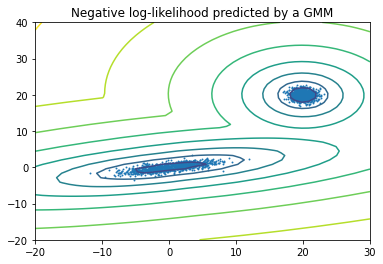

In [ ]:
#density estimation in clusters
#from: https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#sphx-glr-auto-examples-mixture-plot-gmm-pdf-py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 1000

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=3, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))

plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


Data shape:  (1000, 2)
Optimal clusters:  2


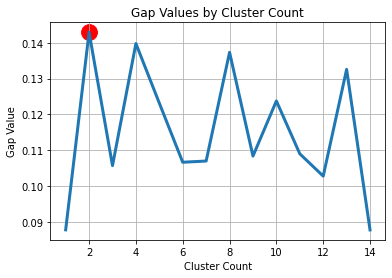

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


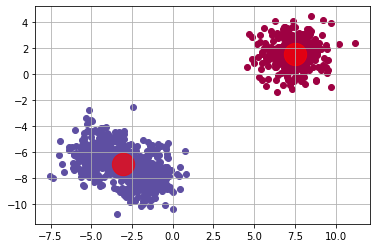

In [ ]:
#from : https://github.com/milesgranger/gap_statistic/blob/master/Example.ipynb
#gap statistics


%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gap_statistic import OptimalK
try:
    from sklearn.datasets.samples_generator import make_blobs
except ImportError:
    from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

#np.random.seed(0)
optimalK = OptimalK(parallel_backend='rust')

X, y = make_blobs(n_samples=int(1e3), n_features=2, centers=3, random_state=25)
print('Data shape: ', X.shape)

n_clusters = optimalK(X, cluster_array=np.arange(1, 15))
print('Optimal clusters: ', n_clusters)

optimalK.gap_df.head()

#plot
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()


# Now that we have the optimal clusters, n, we build our own KMeans model...
km = KMeans(n_clusters)
km.fit(X)

df = pd.DataFrame(X, columns=['x','y'])
df['label'] = km.labels_

colors = plt.cm.Spectral(np.linspace(0, 1, len(df.label.unique())))

for color, label in zip(colors, df.label.unique()):
    
    tempdf = df[df.label == label]
    plt.scatter(tempdf.x, tempdf.y, c=color)
    
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], c='r', s=500, alpha=0.7, )
plt.grid(True)
plt.show()

Optimal clusters:  10


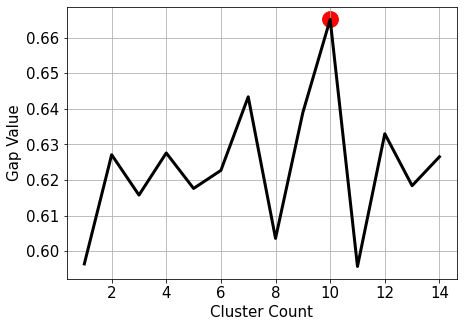

no  clusters meanshift:  1


AttributeError: ignored

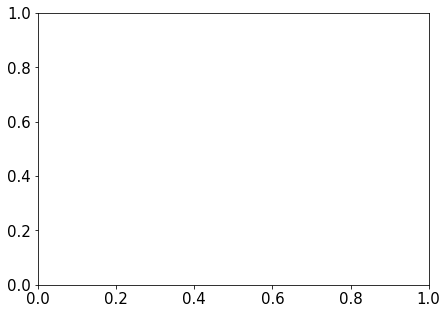

In [ ]:
#from : https://github.com/milesgranger/gap_statistic/blob/master/Example.ipynb
#meanshift

# We'll wrap the `MeanShift` algorithm from sklearn

from sklearn.cluster import MeanShift

def special_clustering_func(X, k):
    """ 
    Special clustering function which uses the MeanShift
    model from sklearn.
    
    These user defined functions *must* take the X and a k 
    and can take an arbitrary number of other kwargs, which can
    be pass with `clusterer_kwargs` when initializing OptimalK
    """
    
    # Here you can do whatever clustering algorithm you heart desires,
    # but we'll do a simple wrap of the MeanShift model in sklearn.
    
    m = MeanShift()
    m.fit(X)
    
    # Return the location of each cluster center,
    # and the labels for each point.
    return m.cluster_centers_, m.predict(X)

def special_clustering_func_2(X, k):
    """ 
    Special clustering function which uses the MeanShift
    model from sklearn.
    
    These user defined functions *must* take the X and a k 
    and can take an arbitrary number of other kwargs, which can
    be pass with `clusterer_kwargs` when initializing OptimalK
    """
    
    # Here you can do whatever clustering algorithm you heart desires,
    # but we'll do a simple wrap of the MeanShift model in sklearn.
    
    m = KMeans(k)
    m.fit(X)
    
    # Return the location of each cluster center,
    # and the labels for each point.
    return m.cluster_centers_, m.predict(X)

# Make some data
centers = [[0, 1], [1.5, 1.5], [1,1]]
stds = [0.2, 0.2, 0.2]
points, labels_true = make_blobs(n_samples=1000, centers=centers, cluster_std=stds, random_state=0)

#optimal clustering
np.random.seed(0)
optimalK = OptimalK(parallel_backend='rust')
n_clusters = optimalK(points, cluster_array=range(1, 15))
print('Optimal clusters: ', n_clusters)

#plot
#n_clusters = optimalK(points, cluster_array=np.arange(1, 15))
np.random.seed(0)
optimalK.gap_df.head()

#plot
fig = plt.figure(figsize = (7, 5)) 
ax = fig.add_subplot(111)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
          ax.get_xticklabels() + ax.get_yticklabels()):
          item.set_fontsize(15)
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3, color="black")
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count',fontsize=15)
plt.ylabel('Gap Value',fontsize=15)
#plt.title('Gap Values by Cluster Count')
plt.show()

# Define the OptimalK instance, but pass in our own clustering function
optimalk2 = OptimalK(clusterer=special_clustering_func)

# Use the callable instance as normal.
n_clusters2 = optimalk2(points, cluster_array=range(1, 15))

print("no  clusters meanshift: ",n_clusters2)

#plot
fig = plt.figure(figsize = (7, 5)) 
ax1 = fig.add_subplot(111)
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
          ax1.get_xticklabels() + ax1.get_yticklabels()):
          item.set_fontsize(15)
plt.plot(optimalK.gap_df.n_clusters2, optimalK.gap_df.gap_value, linewidth=3, color="black")
#plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters2 == n_clusters2].n_clusters2,
            #optimalK.gap_df[optimalK.gap_df.n_clusters2 == n_clusters2].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count',fontsize=15)
plt.ylabel('Gap Value',fontsize=15)
#plt.title('Gap Values by Cluster Count')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


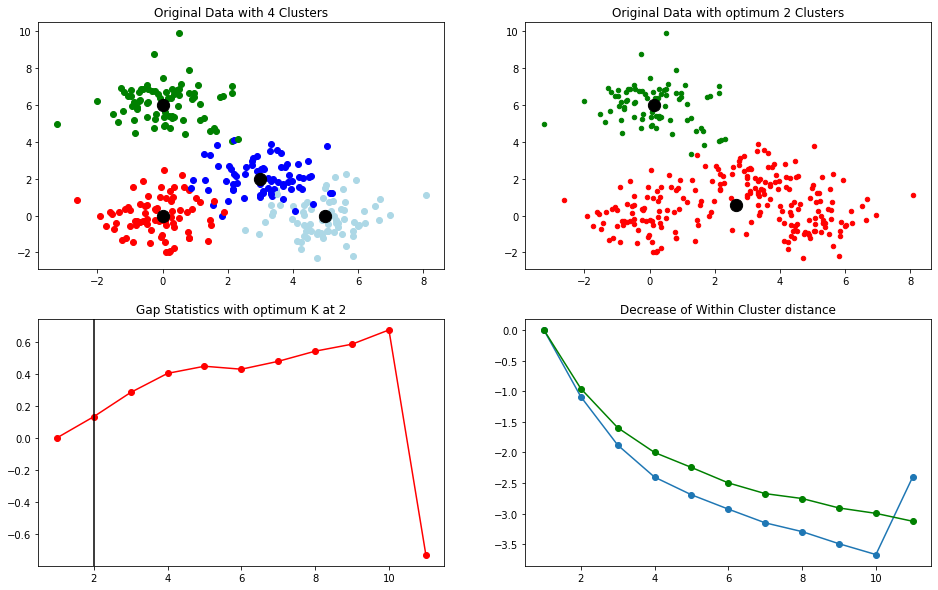

In [ ]:
#from : https://github.com/Mavengence/Pattern_Analysis_SS20_FAU/blob/master/Exercise_6.ipynb

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.spatial import distance
from scipy.ndimage.interpolation import shift
import scipy
from IPython.display import Image
import seaborn as sns

np.random.seed(0)

def kmeans(num_centers, X):
    centers = np.random.uniform(np.min(X[0]), np.max(X[0]), size=(num_centers, 2))
    
    for _ in range(10):

        assigned_to_clusters = np.zeros(len(X))

        for i, x in enumerate(X):
            closest_center = np.argmin([np.linalg.norm(x - center) for center in centers]) 
            assigned_to_clusters[i] = closest_center

        new_centers = np.array([np.mean(X[assigned_to_clusters == i], axis=0) for i in range(num_centers)])    
        convergence = np.sum(np.abs(new_centers - centers))
        centers = new_centers
    
    return np.array(new_centers), np.array(assigned_to_clusters)

def calculate_Wk(Ks, input_data):
    e = np.finfo(float).eps
    if(len(input_data) == 2):
        X = input_data[0]
        label = input_data[1]
    else:
        X = input_data
    
    Ks = np.arange(1,Ks+1)
    within_cluster_dists = []
    
    for K in Ks:

        dists = 0
        centroids, points = kmeans(K, X)

        for i in range(K):
            cluster_array = X[points == i]
            centroid_dist = [] 
            dist = 0

            if len(cluster_array) > 0:
                for j in range(len(cluster_array)):
                    centroid_dist.append(np.linalg.norm(centroids[i] - cluster_array[j]))

            dist += np.sum(centroid_dist)
            dists += dist + e

        within_cluster_dists.append(np.log(((dists + e) / K)))
        
        normalized_wcd = within_cluster_dists - np.max(within_cluster_dists)
    
    return normalized_wcd


def simulate(iterations, K):
    e = np.finfo(float).eps
    simulated_Wk = np.zeros((iterations, K)) + e 
    simulated_sk = np.zeros((iterations, K)) + e
    
    for i in range(iterations):
        
        temp_wk = []
        temp_sk = []
        
        X = np.random.uniform(0, 1, size=(300, 2))
        
        within_cluster_dists = calculate_Wk(K, X)
                    
        simulated_Wk[i] = within_cluster_dists
        
    Wks = np.mean(simulated_Wk + e, axis=0)
    sks = np.std(simulated_Wk + e, axis=0) * np.sqrt(1 + 1/20)
    
    
    return Wks, sks


def shift_to_one(shift, to_range):
    shifted = np.zeros(to_range)
    shifted[1:] = shift
    shifted[0] = np.nan 
    return shifted


def start_gap_statistics(simulations, Ks, input_data, input_centers):
    
    if(len(input_data) == 2):
        data = input_data[0]
        label = input_data[1]
    else:
        data = input_data
        
    colors = {0: "red", 1: "green", 2: 'blue', 3:'lightblue', 4:'yellow', 5:'pink', 6:'orange', 7:'purple',
         8:'magenta'}
    
    Wks, sks = simulate(simulations, Ks)
    within_cluster_dists = calculate_Wk(Ks, data)
    G = Wks - within_cluster_dists
    
    shifted_wks = shift_to_one(Wks, Ks+1)
    shifted_sks = shift_to_one(sks, Ks+1)
    shifted_g = shift_to_one(G, Ks+1)
    shifted_wcd = shift_to_one(within_cluster_dists, Ks+1)
    
    
    optimum = 0
    
    # THE GAP STATISTICS FORMULA FROM THE SCRIPT
    for i in range(0, len(G) - 1):
        if(G[i] >= G[i+1] - sks[i+1]):
            optimum = i
            break
    
    if optimum == 0:
        optimum = 1
        
    plt.figure(figsize=(16,10))
    
    mapped_colors = [colors[i] for i in label]
    
    # Top Left
    plt.subplot(2, 2, 1)       
    for i, x in enumerate(data):
        plt.scatter(x[0], x[1], color=mapped_colors[i], cmap='rainbow')
    
    for j in range(len(input_centers)):
        plt.scatter(input_centers[j][0], input_centers[j][1], color="black", s=150)
    
    plt.title("Original Data with {} Clusters".format(len(input_centers)))
    
    # Bottom right
    plt.subplot(2, 2, 4)        
    plt.plot(shifted_wcd, '-o', label="Drawn from Data")
    plt.plot(shifted_wks, '-o', color="green", label="Simulated")
    plt.title("Decrease of Within Cluster distance")
    
    # Bottom left
    plt.subplot(2, 2, 3)       
    plt.plot(shifted_g, '-o', color='r')
    plt.axvline(x=optimum, color='black')
    plt.title("Gap Statistics with optimum K at {}".format(optimum))
    
    # Top right    
    plt.subplot(2, 2, 2) 
    center_points, center_arrays = kmeans(optimum, data)
    centers = center_points
    color_array = center_arrays
    color = np.array([colors[x] for x in color_array])
      
    for j in range(optimum):

        points = data[color == colors[j]]
        c = colors[j]

        plt.scatter(points[:,0], points[:,1], color=c, s=20)
        plt.scatter(centers[j][0], centers[j][1], color="black", s=150)
        plt.title("Original Data with optimum {} Clusters".format(optimum))
      
    plt.show()

centers = [[0,0], [0,6], [3,2], [5,0]]
data = make_blobs(n_samples=300, centers=centers, n_features=2, cluster_std=1)

start_gap_statistics(20, 11, data, centers)

Automatically created module for IPython interactive environment


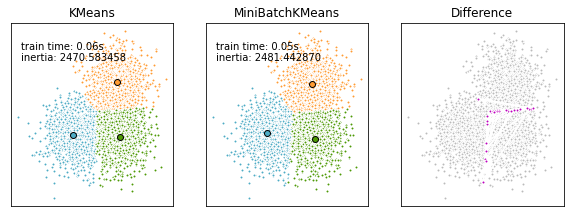

In [ ]:
#from: https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html#sphx-glr-auto-examples-cluster-plot-mini-batch-kmeans-py

print(__doc__)

import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs

# #############################################################################
# Generate sample data
np.random.seed(0)

batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

# #############################################################################
# Compute clustering with Means

k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

# #############################################################################
# Compute clustering with MiniBatchKMeans

mbk = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

# #############################################################################
# Plot result

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

# We want to have the same colors for the same cluster from the
# MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per
# closest one.
k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_,
                                  mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8,  'train time: %.2fs\ninertia: %f' % (
    t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, 'train time: %.2fs\ninertia: %f' %
         (t_mini_batch, mbk.inertia_))

# Initialise the different array to all False
different = (mbk_means_labels == 4)
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += ((k_means_labels == k) != (mbk_means_labels == k))

identic = np.logical_not(different)
ax.plot(X[identic, 0], X[identic, 1], 'w',
        markerfacecolor='#bbbbbb', marker='.')
ax.plot(X[different, 0], X[different, 1], 'w',
        markerfacecolor='m', marker='.')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())

plt.show()

Optimal value: 0.1875847184458806


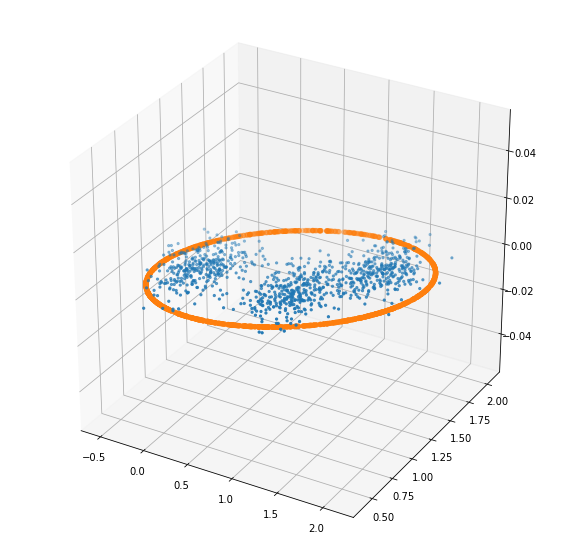

Ellipsoid Volume:  3.4729565846416772


In [ ]:
from mpl_toolkits.mplot3d import axes3d
from scipy.spatial import ConvexHull
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn.datasets
import SimpleITK as sitk
import code



def get_volume_ml(image):
    x_spacing, y_spacing, z_spacing = image.GetSpacing()
    image_nda = sitk.GetArrayFromImage(image)
    imageSegm_nda_NonZero = image_nda.nonzero()
    num_voxels = len(list(zip(imageSegm_nda_NonZero[0],
                              imageSegm_nda_NonZero[1],
                              imageSegm_nda_NonZero[2])))
    if 0 >= num_voxels:
        print('The mask image does not seem to contain an object.')
        return None
    volume_object_ml = (num_voxels * x_spacing * y_spacing * z_spacing) / 1000
    return volume_object_ml

def get_surface_points(dcm_img):
    x_spacing, y_spacing, z_spacing = dcm_img.GetSpacing()
    contour = sitk.LabelContour(dcm_img, fullyConnected=False)
    contours = sitk.GetArrayFromImage(contour)
    vertices_locations = contours.nonzero()

    vertices_unravel = list(zip(vertices_locations[0], vertices_locations[1], vertices_locations[2]))
    vertices_list = [list(vertices_unravel[i]) for i in range(0, len(vertices_unravel))]
    surface_points = np.array(vertices_list)

    surface_points = surface_points.astype(np.float64)

    surface_points[:,0] *= x_spacing/10
    surface_points[:,1] *= y_spacing/10
    surface_points[:,2] *= z_spacing/10

    return surface_points

def get_dcm_image(folder_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(os.path.normpath(folder_path))
    reader.SetFileNames(dicom_names)
    reader.MetaDataDictionaryArrayUpdateOn()
    reader.LoadPrivateTagsOn()
    try:
        dcm_img = reader.Execute()
    except Exception:
        raise Exception('Non-readable DICOM Data: ', folder_path)

    return dcm_img

def GetHull(points):
  dim  = points.shape[1]
  hull = ConvexHull(points)
  A    = hull.equations[:,0:dim]
  b    = hull.equations[:,dim]
  return A, -b, hull #Negative moves b to the RHS of the inequality

def FindMaximumVolumeInscribedEllipsoid(points):
  """Find the inscribed ellipsoid of maximum volume. Return its matrix-offset form."""
  dim = points.shape[1]
  A,b,hull = GetHull(points)

  B = cp.Variable((dim,dim), PSD=True) #Ellipsoid
  d = cp.Variable(dim)                 #Center

  constraints = [cp.norm(B@A[i],2)+A[i]@d<=b[i] for i in range(len(A))]
  prob = cp.Problem(cp.Minimize(-cp.log_det(B)), constraints)
  optval = prob.solve()
  if optval==np.inf:
    raise Exception("No solution possible!")
  print(f"Optimal value: {optval}") 

  return B.value, d.value

#From: https://stackoverflow.com/a/61786434/752843
def random_point_ellipsoid(a,b,c,x0,y0,z0):
    """Generate a random point on an ellipsoid defined by a,b,c"""
    u = np.random.rand()
    v = np.random.rand()
    theta = u * 2.0 * np.pi
    phi = np.arccos(2.0 * v - 1.0)
    sinTheta = np.sin(theta);
    cosTheta = np.cos(theta);
    sinPhi = np.sin(phi);
    cosPhi = np.cos(phi);
    rx = a * sinPhi * cosTheta;
    ry = b * sinPhi * sinTheta;
    rz = c * cosPhi;
    return rx, ry, rz

def Plot(points, B, d):
  hull = ConvexHull(points)
  
  fig = plt.figure(figsize = (10, 10)) 
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(points[:,0], points[:,1], marker=".")
  display_points = np.array([random_point_ellipse([[1,0],[0,1]],[0,0]) for i in range(1000)])
  display_points = display_points@B+d
  ax.scatter(display_points[:,0], display_points[:,1])
  plt.show()


centers = [[0, 1], [1.5, 1.5], [1,1]]
stds = [0.2, 0.2, 0.2]
points, labels_true = make_blobs(n_samples=1000, centers=centers, cluster_std=stds, random_state=0)

B, d = FindMaximumVolumeInscribedEllipsoid(points)

Plot(points, B, d)

ball_vol = 4/3.0*np.pi*(1.0**3)


print("Ellipsoid Volume: ", np.linalg.det(B) * ball_vol)

Optimal value: -0.9519119256782991


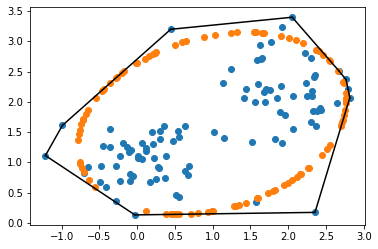

(array([[1.76696555, 0.20888852],
        [0.20888852, 1.49090543]]), array([0.98907488, 1.64734667]))

In [ ]:
#!/usr/bin/env python3

from mpl_toolkits.mplot3d import axes3d
from scipy.spatial import ConvexHull
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets

#From: https://stackoverflow.com/a/61786434/752843


def random_point_ellipse(W,d):
  # random angle
  alpha = 2 * np.pi * np.random.random()
  # vector on that angle
  pt = np.array([np.cos(alpha),np.sin(alpha)])
  #print("pt :",pt)
  # Ellipsoidize it
  return W@pt+d

def GetRandom(dims, Npts):
  if dims==2:
    centers = [[0, 1], [2, 2]]
    stds = [0.2, 0.2]
    points, labels_true = make_blobs(n_samples=100, centers=centers, cluster_std=stds, random_state=0)
  elif dims==3:
    centers = [[0, 1, 0], [1.5, 1.5, 1], [1, 3, 3]]
    stds = [0.2, 0.2, 0.2]
    points, labels_true = make_blobs(n_samples=1000, centers=centers, cluster_std=stds, random_state=0)
  else:
    raise Exception("dims must be 2 or 3!")
  noise = np.random.multivariate_normal(mean=[0]*dims, cov=0.2*np.eye(dims), size=Npts)
  return points+noise

def GetHull(points):
  dim  = points.shape[1]
  hull = ConvexHull(points)
  A    = hull.equations[:,0:dim]
  b    = hull.equations[:,dim]
  return A, -b, hull #Negative moves b to the RHS of the inequality

def Plot(points, hull, B, d):
  fig = plt.figure()
  if points.shape[1]==2:
    ax = fig.add_subplot(111)
    ax.scatter(points[:,0], points[:,1])
    for simplex in hull.simplices:
      plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    display_points = np.array([random_point_ellipse([[1,0],[0,1]],[0,0]) for i in range(100)])
    display_points = display_points@B+d
    ax.scatter(display_points[:,0], display_points[:,1])
  elif points.shape[1]==3:
    fig = plt.figure(figsize = (15, 10)) 
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2])
    display_points = np.array([random_point_ellipse([[1,0,0],[0,1,0],[0,0,1]],[0,0,0]) for i in range(1000)])
    display_points = display_points@B+d
    ax.scatter(display_points[:,0], display_points[:,1], display_points[:,2])
  plt.show()

def FindMaximumVolumeInscribedEllipsoid(points):
  """Find the inscribed ellipsoid of maximum volume. Return its matrix-offset form."""
  dim = points.shape[1]
  A,b,hull = GetHull(points)

  B = cp.Variable((dim,dim), PSD=True) #Ellipsoid
  d = cp.Variable(dim)                 #Center

  constraints = [cp.norm(B@A[i],2)+A[i]@d<=b[i] for i in range(len(A))]
  prob = cp.Problem(cp.Minimize(-cp.log_det(B)), constraints)
  optval = prob.solve()
  if optval==np.inf:
    raise Exception("No solution possible!")
  print(f"Optimal value: {optval}") 

  Plot(points, hull, B.value, d.value)

  return B.value, d.value

FindMaximumVolumeInscribedEllipsoid(GetRandom(dims=2, Npts=100))
#FindMaximumVolumeInscribedEllipsoid(GetRandom(dims=3, Npts=1000))



In [ ]:
l;[]